# Results of linear vs circular embedding experiments

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns
import plotly.express as px

import numpy as np
import pandas as pd
import polars as pl

import statsmodels.formula.api as smf
import statsmodels.api as sm

import torch

In [11]:
from workingModels import FaceAngle
from datageneration.faces.rotated_olivetti import FaceDataset

import glob
from scipy.stats import uniform, norm, vonmises

losses = {'linear': torch.nn.Identity(), 'sqrt': torch.sqrt, 'square': lambda x: x**2,
          'quart': lambda x: x**4, 'root4': lambda x: x**0.25,
          'log': torch.log}
distributions = {
        'linear': {'uniform': uniform(-torch.pi/2, torch.pi).rvs,
                   'concentrated': norm(torch.pi/4, 0.2).rvs},
        'circular': {'uniform': uniform(-torch.pi, 2*torch.pi).rvs,
                     'concentrated': vonmises(torch.pi/2, 2.).rvs}
        }

def load_model(loss, encoding, distribution, rep, optimal_for):
    ckpt = glob.glob(
        f'trainedParameters/Exp2.2/{loss}_loss/{encoding}_enc/{distribution}/rep{rep}/{optimal_for}*'
    )[0]

    lossFn = losses[loss]
    sample_dist = distributions[encoding][distribution]
    
    model = FaceAngle.load_from_checkpoint(ckpt,
                                        loss_pair=(loss, lossFn),
                                        distribution_pair=(distribution, sample_dist),
                                        encoding=encoding)
    return model

# make a dataset over the angles given.
def make_data(angles, split='train'):
    numbers = (300, 50, 50)
    all_angles = np.repeat(angles, numbers[0])
    
    dataset = FaceDataset(all_angles, split=split, numbers=numbers)
    return dataset



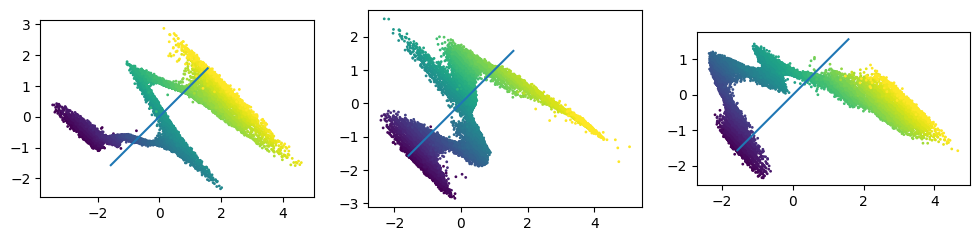

In [136]:
figsize(12,6)
plt.subplots(1,3)

train_data = make_data(np.linspace(-np.pi/2, np.pi/2))

for rep in range(3):
    model = load_model('linear', 'linear', 'uniform', rep, 'train')
    outs = model.forward(train_data[:]['image'].to(model.device)).cpu().detach()
    plt.subplot(1,3,rep+1)
    plt.scatter(outs[:, 0], outs[:,1], c=train_data[:]['angle'], s=1)
    plt.plot(np.linspace(-np.pi/2, np.pi/2), np.linspace(-np.pi/2, np.pi/2))
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')

Above: linear embedding, uniform distribution

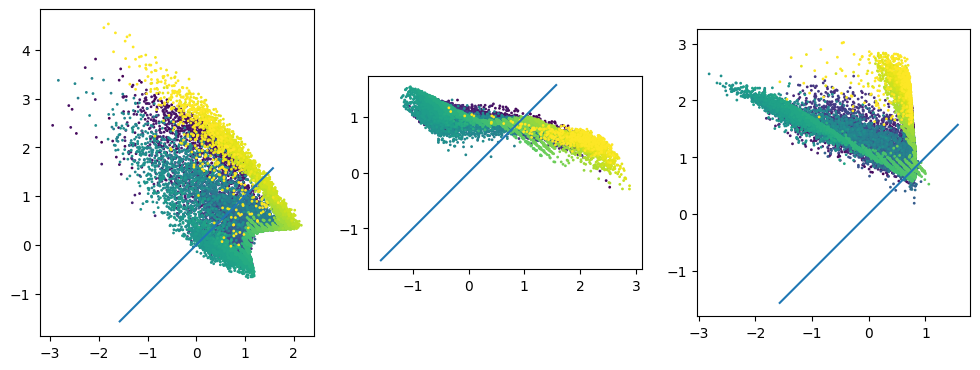

In [129]:
figsize(12,6)
plt.subplots(1,3)

train_data = make_data(np.linspace(-np.pi/2, np.pi/2))

for rep in range(3):
    model = load_model('linear', 'linear', 'concentrated', rep, 'train')
    outs = model.forward(train_data[:]['image'].to(model.device)).cpu().detach()
    plt.subplot(1,3,rep+1)
    plt.scatter(outs[:, 0], outs[:,1], c=train_data[:]['angle'], s=1)
    plt.plot(np.linspace(-np.pi/2, np.pi/2), np.linspace(-np.pi/2, np.pi/2))
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')

Above: linear embedding, concentrated distribution

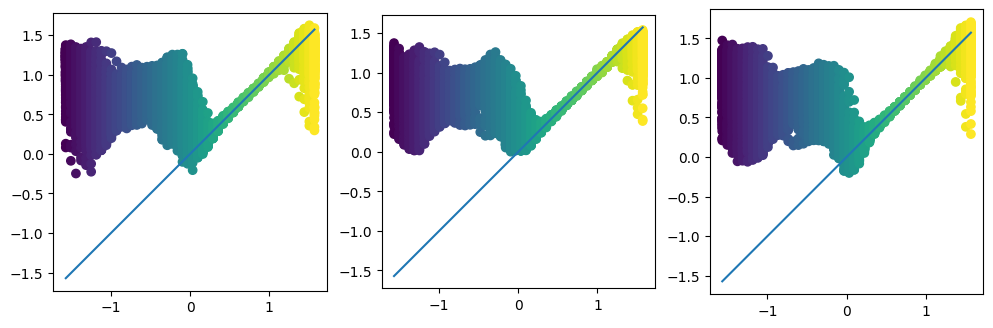

In [254]:
figsize(12,6)
plt.subplots(1,3)

train_data = make_data(np.linspace(-np.pi/2, np.pi/2))

for rep in range(3):
    model = load_model('linear', 'linear', 'concentrated', rep, 'train')
    outs = model.forward(train_data[:]['image'].to(model.device)).cpu().detach()
    plt.subplot(1,3,rep+1)

    plt.scatter(train_data[:]['angle'], model.decodeAngles(outs), c=train_data[:]['angle']) 
    plt.plot(np.linspace(-np.pi/2, np.pi/2), np.linspace(-np.pi/2, np.pi/2))
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')

Above: linear embedding, concentrated distribution angle decoded

It is somewhat difficult to interpret the learned embeddings for concentrated distributions, but the MSEs look good.

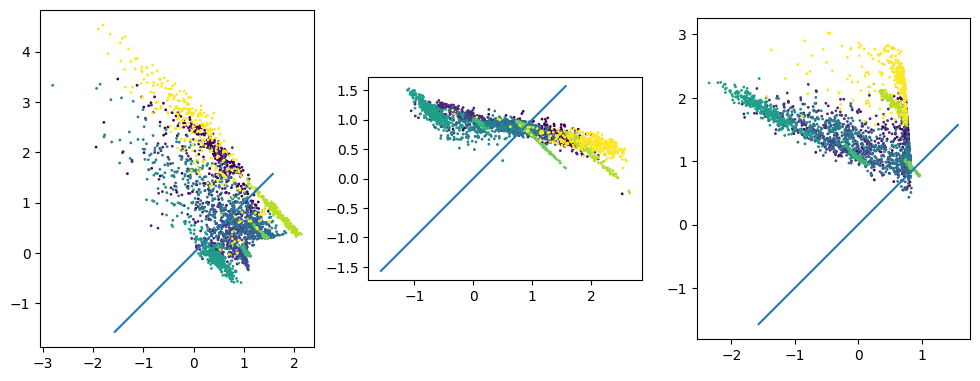

In [134]:
figsize(12,6)
plt.subplots(1,3)

train_data = make_data(np.linspace(-np.pi/2, np.pi/2, 10))

for rep in range(3):
    model = load_model('linear', 'linear', 'concentrated', rep, 'train')
    outs = model.forward(train_data[:]['image'].to(model.device)).cpu().detach()
    plt.subplot(1,3,rep+1)
    plt.scatter(outs[:, 0], outs[:,1], c=train_data[:]['angle'], s=1)
    plt.plot(np.linspace(-np.pi/2, np.pi/2), np.linspace(-np.pi/2, np.pi/2))
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')

The really showcases the variety of embedding profiles that we can get for different locations and different models.

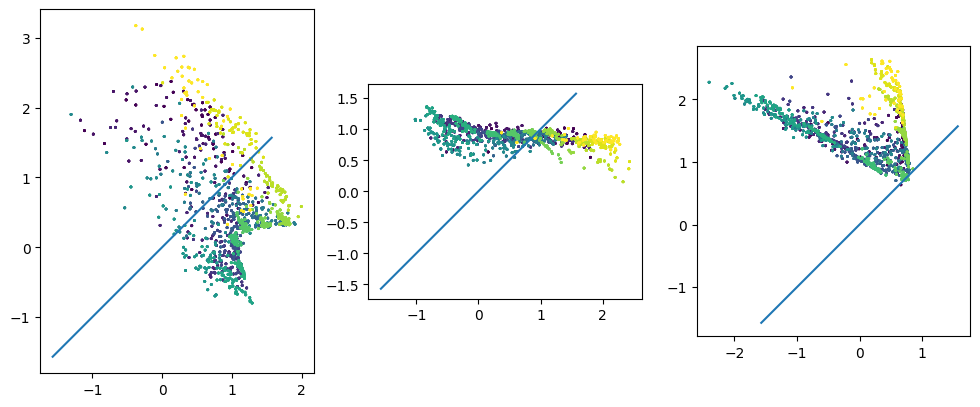

In [139]:
figsize(12,6)
plt.subplots(1,3)

train_data = make_data(np.linspace(-np.pi/2, np.pi/2, 20), split='test')

for rep in range(3):
    model = load_model('linear', 'linear', 'concentrated', rep, 'validation')
    outs = model.forward(train_data[:]['image'].to(model.device)).cpu().detach()
    plt.subplot(1,3,rep+1)
    plt.scatter(outs[:, 0], outs[:,1], c=train_data[:]['angle'], s=1)
    plt.plot(np.linspace(-np.pi/2, np.pi/2), np.linspace(-np.pi/2, np.pi/2))
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')

Above: linear embedding, concentrated distribution, test data

### Studying the noise features of distributions for one model

The real question is how well these distributions are captured by gaussian distributions

tensor([-0.1189, -0.0227])
tensor([0.0229, 0.0218])
tensor([-0.0993, -0.0191])
tensor([ 0.0060, -0.0074])
tensor([-0.0008,  0.0008])
tensor([-0.1627, -0.0056])


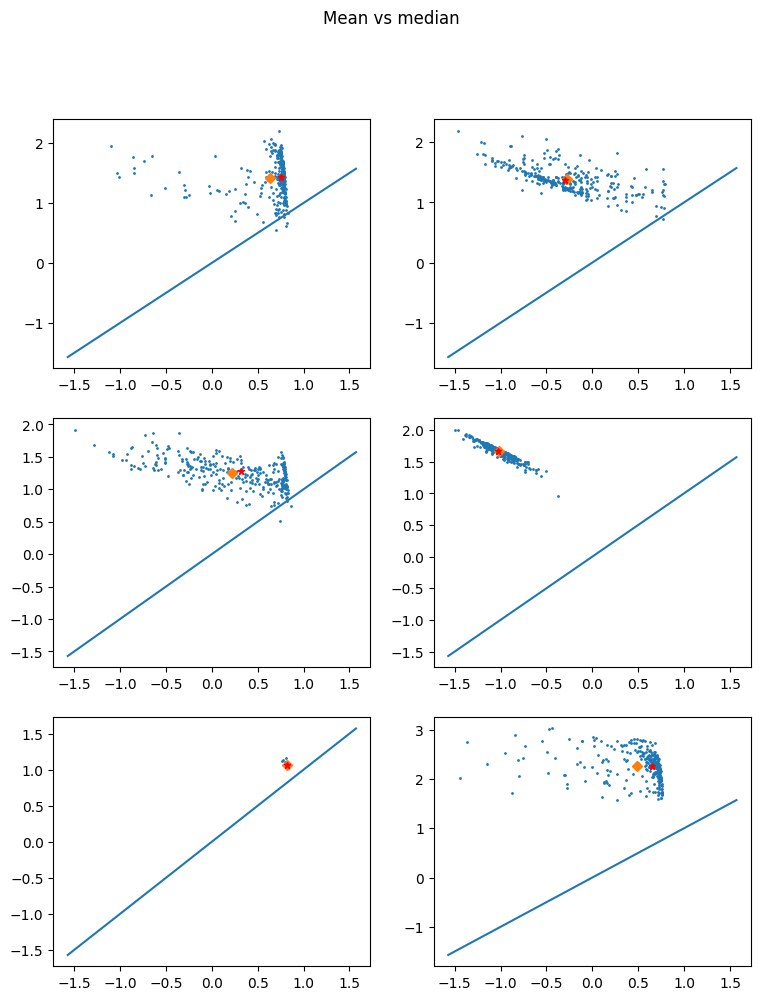

In [250]:
figsize(9,11)
plt.subplots(3,2)
plt.suptitle('Mean vs median')
model = load_model('linear', 'linear', 'concentrated', 2, 'train')


for i, angle in enumerate(np.linspace(-np.pi/2, np.pi/2, 6)):
    train_data = make_data(angle)
    outs = model.forward(train_data[:]['image'].to(model.device)).cpu().detach()

    plt.subplot(3, 2,i+1)
    plt.scatter(outs[:, 0], outs[:,1],  s=1)
    plt.plot(np.linspace(-np.pi/2, np.pi/2), np.linspace(-np.pi/2, np.pi/2))
    ax.set_aspect('equal', adjustable='box')

    raw_mean = outs.mean(0)
    median = outs.median(0).values
    print(raw_mean - median)
    plt.plot(raw_mean[0], raw_mean[1], 'D', markersize=5)
    plt.plot(median[0], median[1], '*r', markersize=5)

#### Interesting:
the mean and median are often, but not always close to each other.
Neither seems to necessarily line up with where the bulk of the data seems to lie by eye.

Odd, that the median is not even less sensitive to this, but I guess thats what happens when 

Note also the one place where the representation is extremely well concentrated.

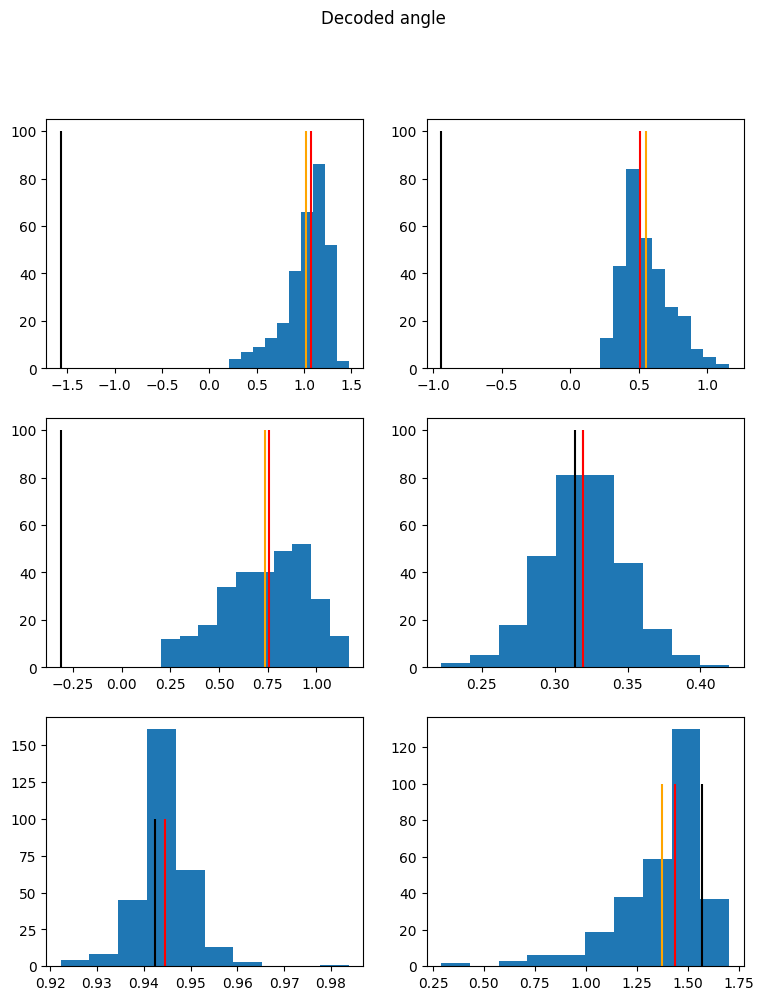

In [253]:
figsize(9,11)
plt.subplots(3,2)
plt.suptitle('Decoded angle')
model = load_model('linear', 'linear', 'concentrated', 2, 'train')

for i, angle in enumerate(np.linspace(-np.pi/2, np.pi/2, 6)):
    train_data = make_data(angle)
    outs = model.forward(train_data[:]['image'].to(model.device)).cpu().detach()
    angles_out = model.decodeAngles(outs)
    
    plt.subplot(3, 2,i+1)
    plt.hist(angles_out)
    plt.vlines([angles_out.mean()], 0, 100, 'orange')
    plt.vlines([angles_out.median()], 0, 100, 'r')

    plt.vlines([angle], 0, 100, 'k')


There is definite skew in the decoded angle

Ok, this is definitely a factor in the noisiness of our previous estimates of Fisher information.

### Examining the differences in angles close to optimal

Text(0.5, 1.0, 'angles close to optimal')

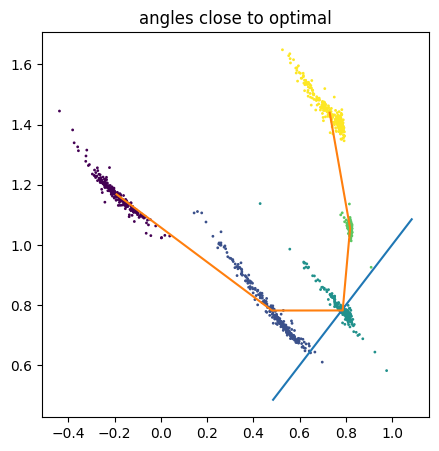

In [576]:
figsize(5,5)
stimuli = np.linspace(-0.3, 0.3, 5) + np.pi/4

train_data = make_data(stimuli)
outs = model.forward(train_data[:]['image'].to(model.device)).cpu().detach()

plt.scatter(outs[:, 0], outs[:,1],  c=train_data[:]['angle'], s=1)
plt.plot(stimuli, stimuli)

means = torch.stack(list(map(lambda x: x.mean(0), outs.split(300))))
plt.plot(means[:,0], means[:,1])

ax.set_aspect('equal', adjustable='box')
plt.title('angles close to optimal')


Ok.... This actually highlights another issue with using the Fisher information that I never thought about before.

A lot of the variance in these distributions does run along the line between the means.
That's because both the variance and the mean difference show large changes in a direction that is not important to the decoded output.

This, in turn, makes the Fisher information of the code small, even though it is actually a very low error encoding. In fact, it shows exactly the type of behavior that I was hoping to see out of this set of experiments! But will be guaranteed to produce low Fisher information measurements out.

It almost seems like we want to examine how well large changes and large variance align, and vice verse. Or like we should scale the variance to the mean diffence... something like that.

#### Returning back to this:

I don't think it's as big of a deal as I made it sound in this writing. The large variance in one direction means that mean differences in that direction are not really all that important. As, indeed they are not. This naturally up-weights the important direction.

More generally, I don't think robust mean and varaince estimators are the solution to non-gaussianity of the data. Instead, we should use a discriminability measurement. Linear discriminability w/ SVMs is probably fine.
 

Text(0.5, 1.0, 'angles close to optimal')

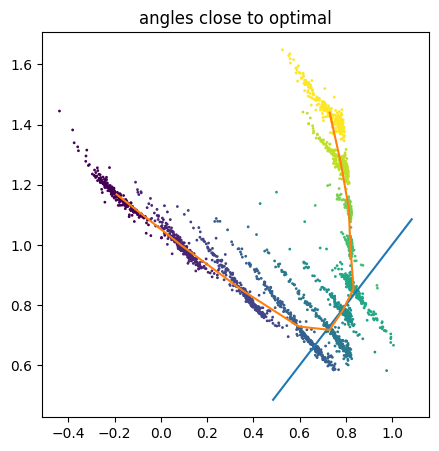

In [287]:
stimuli = np.linspace(-0.3, 0.3, 11) + np.pi/4

train_data = make_data(stimuli)
outs = model.forward(train_data[:]['image'].to(model.device)).cpu().detach()

plt.scatter(outs[:, 0], outs[:,1],  c=train_data[:]['angle'], s=1)
plt.plot(stimuli, stimuli)

means = torch.stack(list(map(lambda x: x.mean(0), outs.split(300))))
plt.plot(means[:,0], means[:,1])

ax.set_aspect('equal', adjustable='box')
plt.title('angles close to optimal')

We have to get fairly fine grained before we see noise that could possibly change the decoded value of the data points.

### Mean changes vs network derivatives

Another, maybe larger, problem that shows up here is that the mean differences on either side of a given point are not the same. Which of these, if either agrees with the network derivative?

Text(0.5, 1.0, 'Network derivatives')

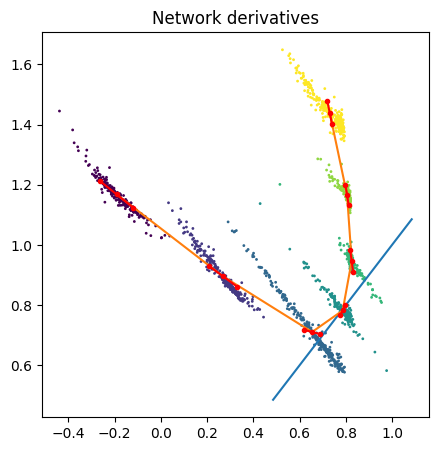

In [417]:
n= 7
image_delta = 0.05



def make_data(angles, split='train'):
    numbers = (300, 50, 50)
    all_angles = np.repeat(angles, numbers[0])
    
    dataset = FaceDataset(all_angles, split=split, numbers=numbers)
    return dataset


stimuli = np.linspace(-0.3, 0.3, n) + np.pi/4

train_data = make_data(stimuli)
I0 = train_data[:]['image'].to(model.device)
I0.requires_grad = True
outs = model.forward(I0).cpu()

# Derivative evaluation: from earlier
mean_grad0 = torch.autograd.grad(outs.mean(0)[0], I0, retain_graph=True)[0].cpu()
mean_grad1 = torch.autograd.grad(outs.mean(0)[1], I0, retain_graph=True)[0].cpu()

plus_I0 = make_data(stimuli + image_delta / 2)[:]['image']
minus_I0 = make_data(stimuli - image_delta / 2)[:]['image']
image_deriv = (plus_I0 - minus_I0) / image_delta 

mean_deriv0 = (mean_grad0 * image_deriv).sum(axis=[1,2])
mean_deriv1 = (mean_grad1 * image_deriv).sum(axis=[1,2])

mean_deriv = torch.stack([mean_deriv0, mean_deriv1]).T

outs = outs.detach()
plt.scatter(outs[:, 0], outs[:,1],  c=train_data[:]['angle'], s=1)
plt.plot(stimuli, stimuli)

means = torch.stack(list(map(lambda x: x.mean(0), outs.split(300))))
plt.plot(means[:,0], means[:,1])


for i, deriv_data in enumerate(torch.split( mean_deriv, 300)):
    d = deriv_data.sum(axis=0)
    ts = np.linspace(-1, 1)

    pairs = torch.stack([means[i] + 0.1*d, means[i], means[i] - 0.1*d])

    plt.plot(pairs[:,0], pairs[:,1], '.-r')


ax.set_aspect('equal', adjustable='box')
plt.title('Network derivatives')

Ok. The network derivatives actually look quite good.

### Covariance level sets

In [444]:
cov = outs[0:300].T.cov()
eigs = torch.linalg.eig(cov)

In [530]:
def mat_sqrt(M):
    eigs = torch.linalg.eig(M)
    return (torch.diag(eigs.eigenvalues)**0.5 @ eigs.eigenvectors.T).real

In [531]:
mat_sqrt(cov).T @ mat_sqrt(cov)

tensor([[ 0.0036, -0.0034],
        [-0.0034,  0.0035]])

In [532]:
cov

tensor([[ 0.0036, -0.0034],
        [-0.0034,  0.0035]])

Text(0.5, 1.0, 'Covariance level sets')

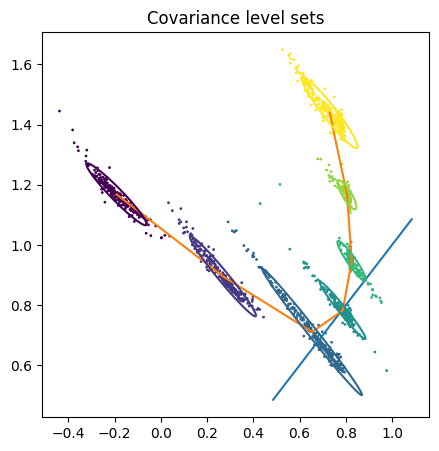

In [577]:
n= 7

stimuli = np.linspace(-0.3, 0.3, n) + np.pi/4

train_data = make_data(stimuli)
I0 = train_data[:]['image'].to(model.device)
I0.requires_grad = True
outs = model.forward(I0).cpu()

outs = outs.detach()
plt.scatter(outs[:, 0], outs[:,1],  c=train_data[:]['angle'], s=1)
plt.plot(stimuli, stimuli)

means = torch.stack(list(map(lambda x: x.mean(0), outs.split(300))))
plt.plot(means[:,0], means[:,1])

angles = torch.linspace(-torch.pi, torch.pi, 50)
unit_circle = torch.stack( [torch.cos(angles), torch.sin(angles) ])

cmap = plt.cm.viridis(np.linspace(0, 1, n))

for i, output_points in enumerate(torch.split(outs, 300)):
    cov =  output_points.T.cov()

    cov_curve = (2*mat_sqrt(cov).T @ unit_circle)  + means[i:i+1].T

    plt.plot(cov_curve[0], cov_curve[1], c=cmap[i])


ax.set_aspect('equal', adjustable='box')
plt.title('Covariance level sets')

Ok, these are the levels sets. Already we can see some issues with the data points seemingly skewed in the dominant direction of the level sets

Text(0.5, 1.0, 'Covariance level sets wider range')

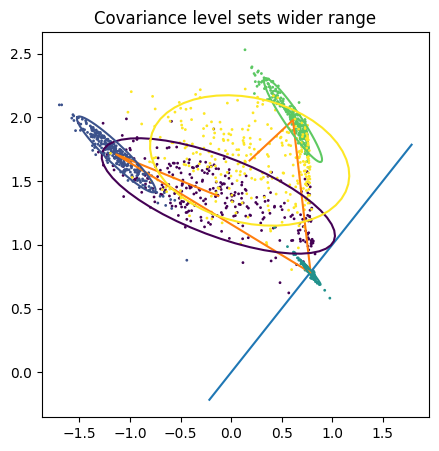

In [557]:
n= 5

stimuli = np.linspace(-1, 1, n) + np.pi/4

train_data = make_data(stimuli)
I0 = train_data[:]['image'].to(model.device)
I0.requires_grad = True
outs = model.forward(I0).cpu()

outs = outs.detach()
plt.scatter(outs[:, 0], outs[:,1],  c=train_data[:]['angle'], s=1)
plt.plot(stimuli, stimuli)

means = torch.stack(list(map(lambda x: x.mean(0), outs.split(300))))
plt.plot(means[:,0], means[:,1])

angles = torch.linspace(-torch.pi, torch.pi, 50)
unit_circle = torch.stack( [torch.cos(angles), torch.sin(angles) ])

cmap = plt.cm.viridis(np.linspace(0, 1, 5))

for i, output_points in enumerate(torch.split(outs, 300)):
    cov =  output_points.T.cov()
    cov_curve = (2*mat_sqrt(cov).T @ unit_circle)  + means[i:i+1].T

    plt.plot(cov_curve[0], cov_curve[1], c=cmap[i])


ax.set_aspect('equal', adjustable='box')
plt.title('Covariance level sets wider range')

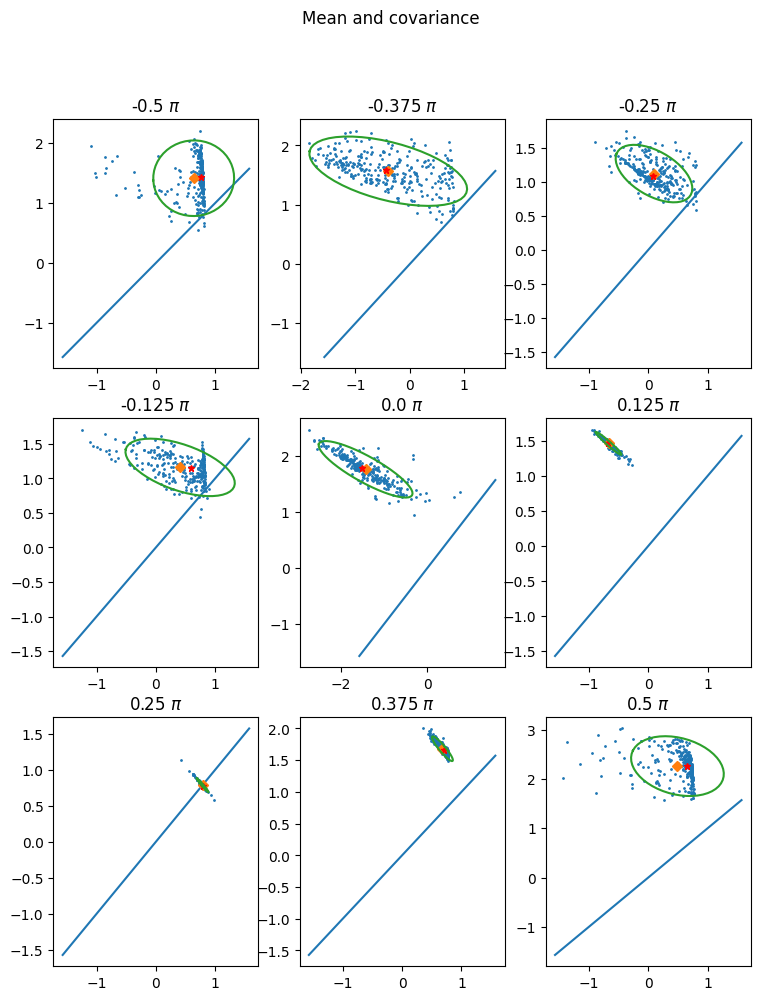

In [574]:
figsize(9,11)
plt.subplots(3,3)
plt.suptitle('Mean and covariance')

angles = torch.linspace(-torch.pi, torch.pi, 50)
unit_circle = torch.stack( [torch.cos(angles), torch.sin(angles) ])


for i, angle in enumerate(np.linspace(-np.pi/2, np.pi/2, 9)):
    train_data = make_data(angle)
    outs = model.forward(train_data[:]['image'].to(model.device)).cpu().detach()

    plt.subplot(3, 3,i+1)
    plt.scatter(outs[:, 0], outs[:,1],  s=1)
    plt.plot(np.linspace(-np.pi/2, np.pi/2), np.linspace(-np.pi/2, np.pi/2))
    ax.set_aspect('equal', adjustable='box')

    mean = outs.mean(0)
    median = outs.median(0).values
    
    cov = outs.T.cov()
    cov_curve = (2*mat_sqrt(cov).T @ unit_circle) + mean[:,None]
    
    plt.plot(mean[0], mean[1], 'D', markersize=5)
    plt.plot(median[0], median[1], '*r', markersize=5)

    plt.plot(cov_curve[0], cov_curve[1])
    plt.title(f'{angle / np.pi} $\pi$')

Yep. As we guessed, the mean and covariance matrix do a reasonable job, but they really don't capture the neuances of the embeddings.

I can definitely see how this could lead to pretty noisy Fisher information measurements.

## Ok, let's just look at the Fisher information results

In [4]:
model = load_model('linear', 'linear', 'concentrated', 2, 'train')

def Fisher_derivatives_faces_mean(model, thetas, image_delta=0.05):
    """ The mean term in the Fisher information, as evaluated by derivatives of the neural network
    """
    def point_Fisher(theta):
        I0 = make_data(torch.zeros(1) + theta, split='train').images.contiguous()
        I0.requires_grad = True

        outputs = model.forward(I0.to(model.device)).cpu()
        model_grad0 = torch.autograd.grad(outputs.mean(0)[0], I0, retain_graph=True)[0]
        model_grad1 = torch.autograd.grad(outputs.mean(0)[1], I0)[0]

        plus_I0 = make_data(torch.zeros(1) + theta + image_delta/2, split='train').images.contiguous()
        minus_I0 = make_data(torch.zeros(1) + theta - image_delta/2, split='train').images.contiguous()
        image_deriv = (plus_I0 - minus_I0) / image_delta 

        full_deriv0 = (model_grad0 * image_deriv).sum().item()
        full_deriv1 = (model_grad1 * image_deriv).sum().item()
        douts = torch.tensor([full_deriv0, full_deriv1])

        cov = outputs.T.cov().detach()
        torch.mps.empty_cache()
        return (douts @ torch.linalg.inv(cov) @ douts).item()

    FIs = np.zeros(len(thetas))
    for i, theta in enumerate(thetas):
        FIs[i] = point_Fisher(theta)

    return FIs

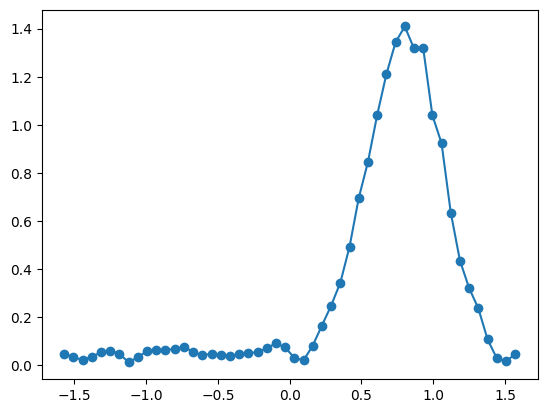

In [4]:
angles = np.linspace(-np.pi/2, np.pi/2, 50)
FIs = Fisher_derivatives_faces_mean(model, angles)

total = np.trapz(FIs**0.5, x=angles)

plt.plot(angles, FIs**0.5 / total, '-o')

Ok, this looks as we would expect. However, it's worth keeping in mind these caveats.

Also worth looking at: the two angles near the peak that are similar.

I think that this cleanliness is partially, but not entirely, a result of the fact that we are training with more data, and evaluating on the training data.

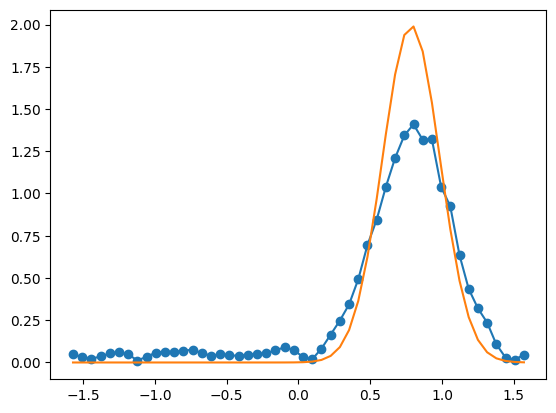

In [5]:
from scipy.stats import norm
plt.plot(angles, FIs**0.5 / total, '-o')
plt.plot(angles, norm(torch.pi/4, 0.2).pdf(angles))

Interestingly, it is 'flatter' than the distribution that it was trained on.

Text(0, 0.5, 'Normalized Fisher Information')

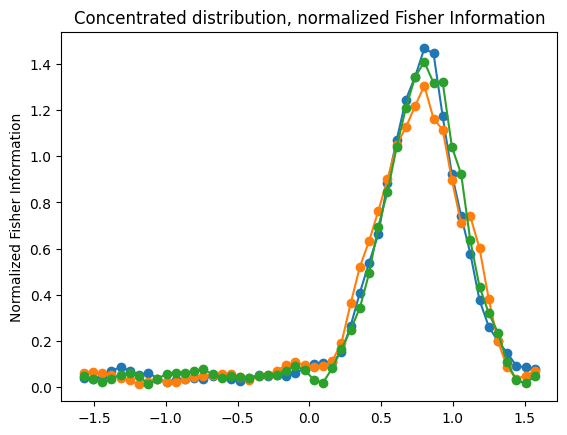

In [6]:
angles = np.linspace(-np.pi/2, np.pi/2, 50)

for rep in range(3):
    model = load_model('linear', 'linear', 'concentrated', rep, 'train')

    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs**0.5, x=angles)
    
    plt.plot(angles, FIs**0.5 / total, '-o')

plt.title('Concentrated distribution, normalized Fisher Information')
plt.ylabel('Normalized Fisher Information')

Text(0, 0.5, 'Normalized Fisher Information')

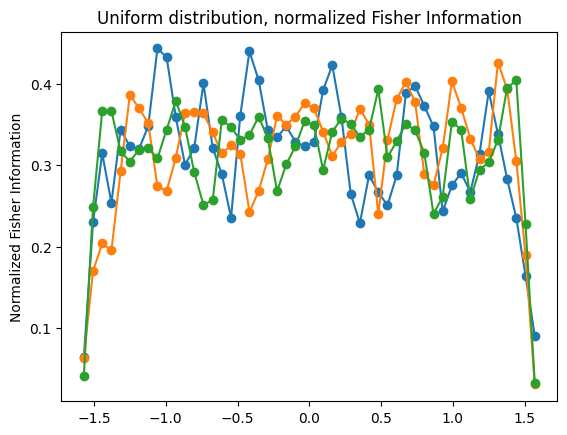

In [7]:
angles = np.linspace(-np.pi/2, np.pi/2, 50)

for rep in range(3):
    model = load_model('linear', 'linear', 'uniform', rep, 'train')

    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs**0.5, x=angles)
    
    plt.plot(angles, FIs**0.5 / total, '-o')

plt.title('Uniform distribution, normalized Fisher Information')
plt.ylabel('Normalized Fisher Information')

Text(0, 0.5, 'Fisher Information')

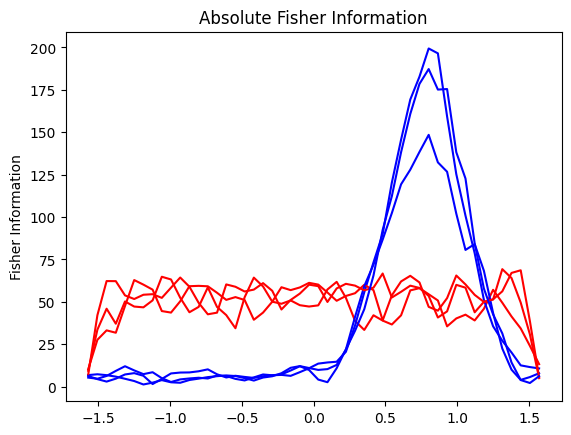

In [8]:
angles = np.linspace(-np.pi/2, np.pi/2, 50)

total_uni =  []
total_conc = []

for rep in range(3):
    model = load_model('linear', 'linear', 'uniform', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs**0.5, x=angles)
    total_uni.append(total)
    
    plt.plot(angles, FIs**0.5, 'r')

    model = load_model('linear', 'linear', 'concentrated', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs**0.5, x=angles)
    total_conc.append(total)
    
    plt.plot(angles, FIs**0.5, 'b')

plt.title('Absolute Fisher Information')
plt.ylabel('Fisher Information')

Text(0.5, 1.0, 'Total Fisher Information')

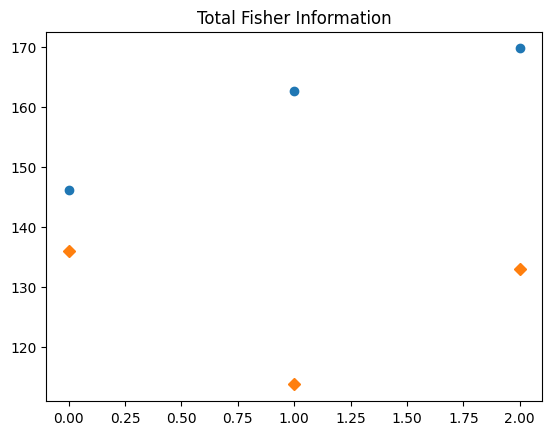

In [9]:
plt.plot(total_uni, 'o')
plt.plot(total_conc, 'D')
plt.title('Total Fisher Information')

There is more total Fisher information for _uniform_ than for _concentrated_ distributions, but not majorly. This is the opposite of my naive expectation.

Also interesting to note is the fact that, in the un-normalized plot, there is one replicate that peaks significantly below the rest, but it looks the same when normalized: this run learned a solution with lower total Fisher information than the others.

#### Overall
These results are very nice. I think the main reasons that they look so clean compared to the previous runs are:
1. We are using the training data, so we are assessing purely the learning behavior, not the generalization.
2. We are using expressive models and a large amount of training data, so the models can be relied upon to find fairly optimal solutions consistently.

### Other setups:

Text(0.5, 1.0, 'Relative Fisher Information - linear loss, linear encoding')

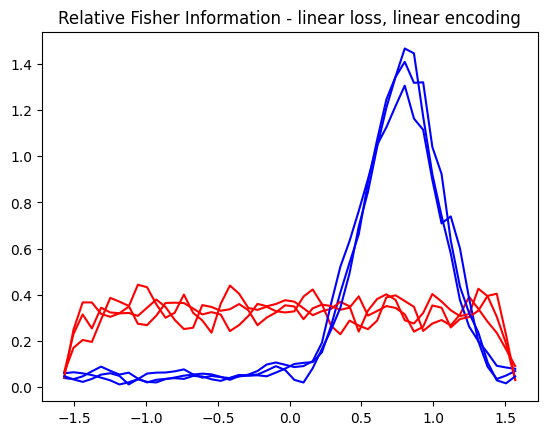

In [10]:
loss = 'linear'
encoding = 'linear'

angles = np.linspace(-np.pi/2, np.pi/2, 50)

for rep in range(3):
    model = load_model(loss, encoding, 'uniform', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs**0.5, x=angles)
    
    plt.plot(angles, FIs**0.5 / total, 'r')

    model = load_model(loss, encoding, 'concentrated', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs**0.5, x=angles)
    
    plt.plot(angles, FIs**0.5 / total, 'b')

plt.title(f'Relative Fisher Information - {loss} loss, {encoding} encoding')

Text(0.5, 1.0, 'Relative Fisher Information - sqrt loss, linear encoding')

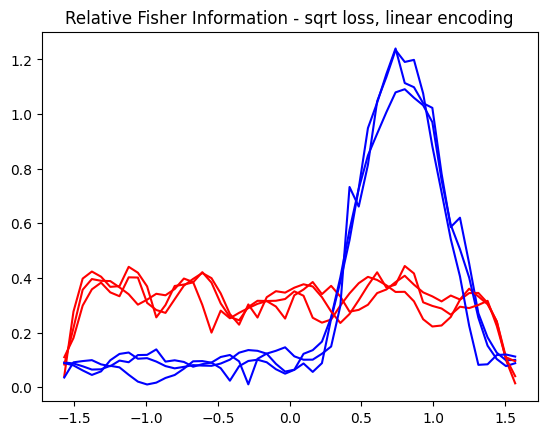

In [11]:
loss = 'sqrt'
encoding = 'linear'

angles = np.linspace(-np.pi/2, np.pi/2, 50)

for rep in range(3):
    model = load_model(loss, encoding, 'uniform', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs**0.5, x=angles)
    
    plt.plot(angles, FIs**0.5 / total, 'r')

    model = load_model(loss, encoding, 'concentrated', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs**0.5, x=angles)
    
    plt.plot(angles, FIs**0.5 / total, 'b')

plt.title(f'Relative Fisher Information - {loss} loss, {encoding} encoding')

Text(0.5, 1.0, 'Relative Fisher Information - linear loss, circular encoding')

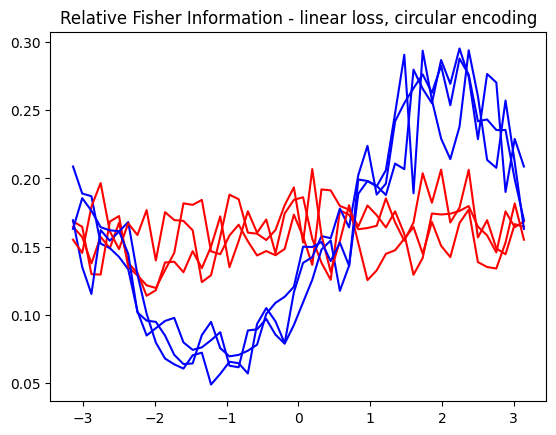

In [12]:
loss = 'linear'
encoding = 'circular'

angles = np.linspace(-np.pi, np.pi, 50)

for rep in range(3):
    model = load_model(loss, encoding, 'uniform', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs**0.5, x=angles)
    
    plt.plot(angles, FIs**0.5 / total, 'r')

    model = load_model(loss, encoding, 'concentrated', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs**0.5, x=angles)
    
    plt.plot(angles, FIs**0.5 / total, 'b')

plt.title(f'Relative Fisher Information - {loss} loss, {encoding} encoding')

Text(0.5, 1.0, 'Relative Fisher Information - sqrt loss, circular encoding')

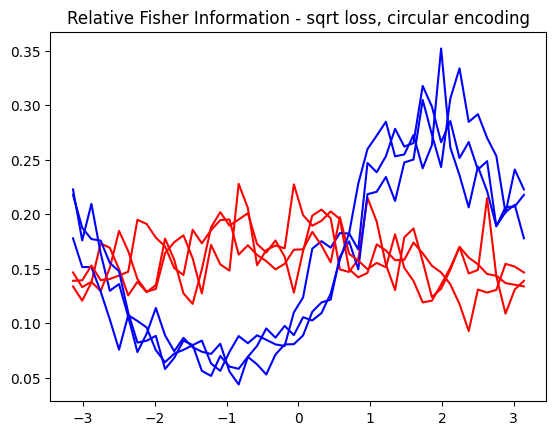

In [13]:
loss = 'sqrt'
encoding = 'circular'

angles = np.linspace(-np.pi, np.pi, 50)

for rep in range(3):
    model = load_model(loss, encoding, 'uniform', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs**0.5, x=angles)
    
    plt.plot(angles, FIs**0.5 / total, 'r')

    model = load_model(loss, encoding, 'concentrated', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs**0.5, x=angles)
    
    plt.plot(angles, FIs**0.5 / total, 'b')

plt.title(f'Relative Fisher Information - {loss} loss, {encoding} encoding')

Interestingly, the Fisher information for the circular embedding does not show the second peak in this case. Why would that be? I don't fully understand it, since I though the reasoning behind the second peak was the encoding that I am imposing of the read-out layer. Could it be that that solution was specific to the small model, low data circumstances that I was working in? If so, that is still very interesting, as it would be revealing about the constraints imposed by model architecture.

Another observation: this concentrated distribution is less impactful than the linear one. It also looks noisier, but that might be simply due to scale.

Text(0.5, 1.0, 'Relative Fisher Information - linear loss, linear encoding')

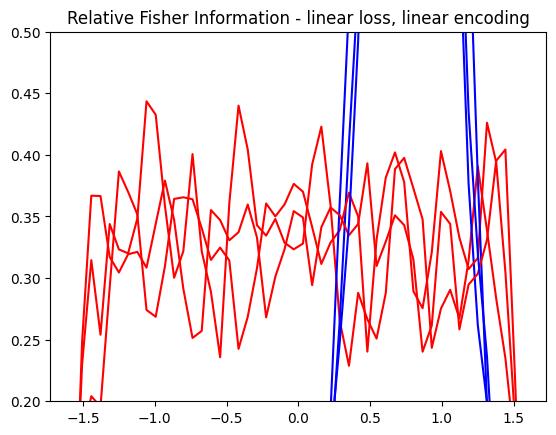

In [14]:
loss = 'linear'
encoding = 'linear'

angles = np.linspace(-np.pi/2, np.pi/2, 50)

for rep in range(3):
    model = load_model(loss, encoding, 'uniform', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs**0.5, x=angles)
    
    plt.plot(angles, FIs**0.5 / total, 'r')

    model = load_model(loss, encoding, 'concentrated', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs**0.5, x=angles)
    
    plt.plot(angles, FIs**0.5 / total, 'b')
    
plt.ylim([0.2, 0.5])
plt.title(f'Relative Fisher Information - {loss} loss, {encoding} encoding')

Matching the scale of linear encodings to that of the circular, we see that the linear encodings are, infact, noisier.

Text(0.5, 1.0, 'Relative Fisher Information - sqrt loss, circular encoding')

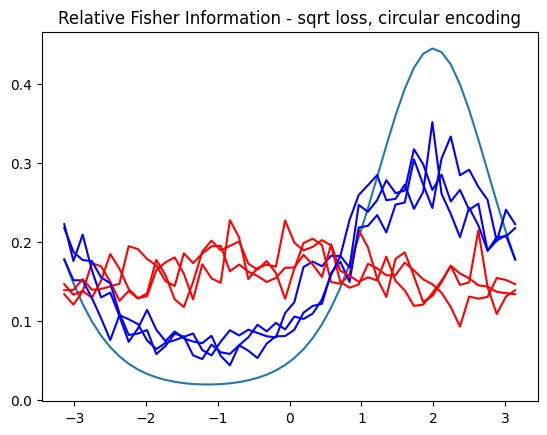

In [15]:
from scipy.stats import vonmises

angle_dist = vonmises(torch.pi/2, 2.)

loss = 'sqrt'
encoding = 'circular'

angles = np.linspace(-np.pi, np.pi, 50)
plt.plot(angles, angle_dist.pdf(angles))


for rep in range(3):
    model = load_model(loss, encoding, 'uniform', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs**0.5, x=angles)
    
    plt.plot(angles, FIs**0.5 / total, 'r')

    model = load_model(loss, encoding, 'concentrated', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs**0.5, x=angles)
    
    plt.plot(angles, FIs**0.5 / total, 'b')

plt.title(f'Relative Fisher Information - {loss} loss, {encoding} encoding')

The circular distribution, similarly to the linear case, significantly undershoots the pdf that it is learning on.

#### Loss function comparison

Text(0.5, 1.0, 'Loss function comparison - linear embedding, concentrated distribution')

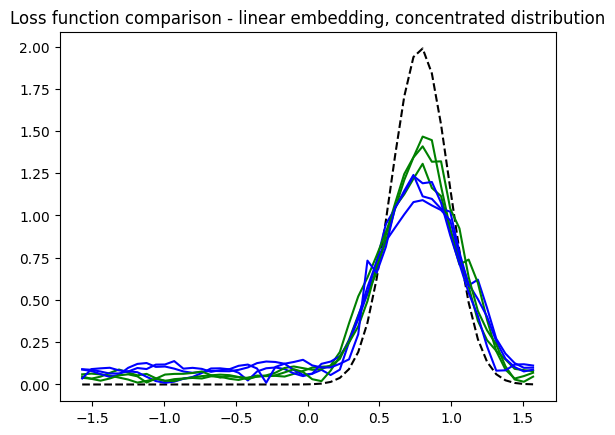

In [16]:
encoding = 'linear'

angles = np.linspace(-np.pi/2, np.pi/2, 50)
plt.plot(angles, norm(torch.pi/4, 0.2).pdf(angles), '--k')


for rep in range(3):
    model = load_model('linear', encoding, 'concentrated', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs**0.5, x=angles)
    total_uni.append(total)
    
    plt.plot(angles, FIs**0.5 / total, 'g')

    model = load_model('sqrt', encoding, 'concentrated', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs**0.5, x=angles)
    
    plt.plot(angles, FIs**0.5 / total, 'b')

plt.title('Loss function comparison - linear embedding, concentrated distribution')

Interestingly, we see what appears to be noticable differences between the linear and square-root objective functions. That is exciting!

Text(0.5, 1.0, 'Loss function comparison - circular embedding, concentrated distribution')

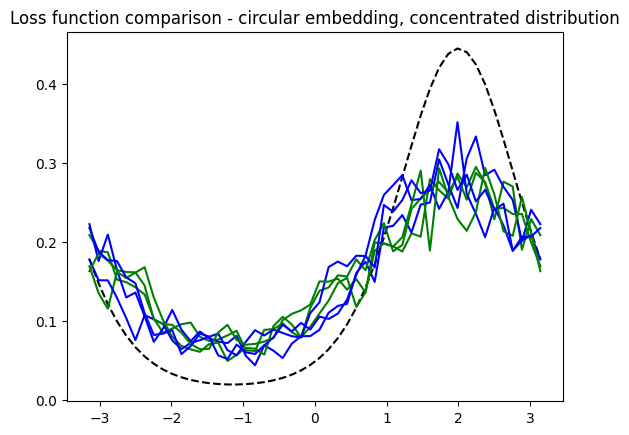

In [17]:
encoding = 'circular'

angles = np.linspace(-np.pi, np.pi, 50)
angle_dist = vonmises(torch.pi/2, 2.)

plt.plot(angles, angle_dist.pdf(angles), '--k')

for rep in range(3):
    model = load_model('linear', encoding, 'concentrated', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs**0.5, x=angles)
    total_uni.append(total)
    
    plt.plot(angles, FIs**0.5 / total, 'g')

    model = load_model('sqrt', encoding, 'concentrated', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs**0.5, x=angles)
    
    plt.plot(angles, FIs**0.5 / total, 'b')

plt.title('Loss function comparison - circular embedding, concentrated distribution')

Much harder to see for circular embeddings.

_Question:_ Are distributions with high concentrations or lower concentrations better for determining the loss function?

### Questions that still remain

The main question that still remains is how to actually test for uniform vs non-uniform Fisher information? They look uniform by eye, but as we saw in the zoomed versions, the Fisher info that we fit is actually quite noisy.
- This is not an super urgent question: we can start with simple, high positive detection rate metrics for uniform. (eg min-max spread)
- This is also where the noisiness / imprecision of our Fisher information metrics comes into play: improving them is also a longer term question, but with implications for improving the other steps in the calculations.

Prefer a robust version of the full pipeline with noisy steps to optiming the steps at the moment.

## Fitting the objective function.

In this example, we've already seen that the code is unconstrained. The next question is to determine what the objective function is.


From the theory, we know that $f'(\sqrt{I_s}) \propto 1 / p(s)$




Text(0.5, 0.98, 'Fisher Information vs probability')

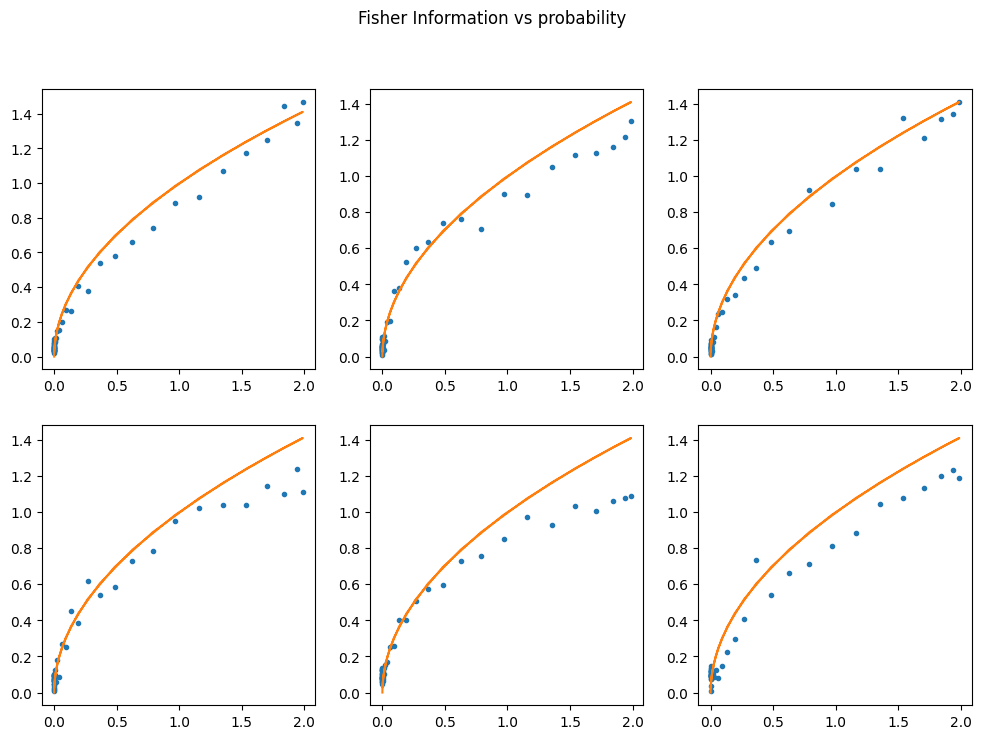

In [15]:
encoding = 'linear'

angles = np.linspace(-np.pi/2, np.pi/2, 50)
probs = norm(torch.pi/4, 0.2).pdf(angles)

figsize(12, 8)
plt.subplots(2,3)

for rep in range(3):
    for row, loss in enumerate(['linear', 'sqrt']):
        plt.subplot(2,3,3*row + rep +1)

        model = load_model(loss, encoding, 'concentrated', rep, 'train')
        FIs = Fisher_derivatives_faces_mean(model, angles)
        total = np.trapz(FIs**0.5, x=angles)
    
        plt.plot(probs, FIs**0.5 / total, '.')
        plt.plot(probs, np.sqrt(probs))

plt.suptitle('Fisher Information vs probability')

Text(0.5, 0.98, 'Fisher Information vs probability')

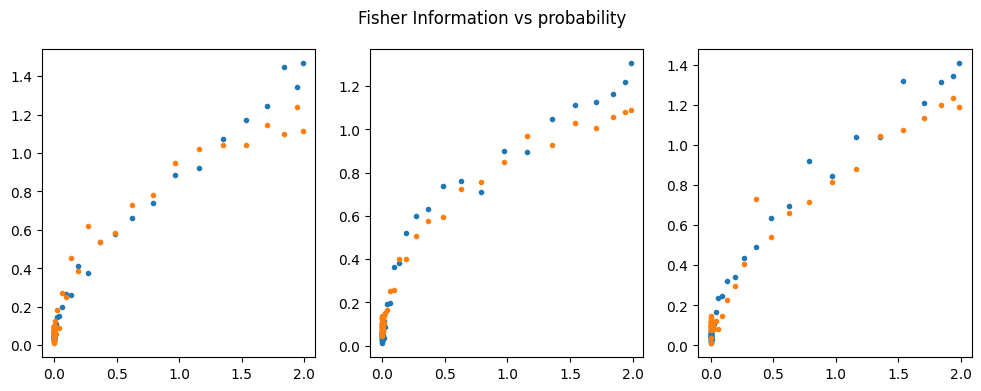

In [19]:
encoding = 'linear'

angles = np.linspace(-np.pi/2, np.pi/2, 50)
probs = norm(torch.pi/4, 0.2).pdf(angles)

figsize(12, 4)
plt.subplots(1,3)

for rep in range(3):
    for row, loss in enumerate(['linear', 'sqrt']):
        plt.subplot(1,3,rep +1)

        model = load_model(loss, encoding, 'concentrated', rep, 'train')
        FIs = Fisher_derivatives_faces_mean(model, angles)
        total = np.trapz(FIs**0.5, x=angles)
    
        plt.plot(probs, FIs**0.5 / total, '.')

plt.suptitle('Fisher Information vs probability')

Text(0.5, 0.98, 'Fisher Information vs probability')

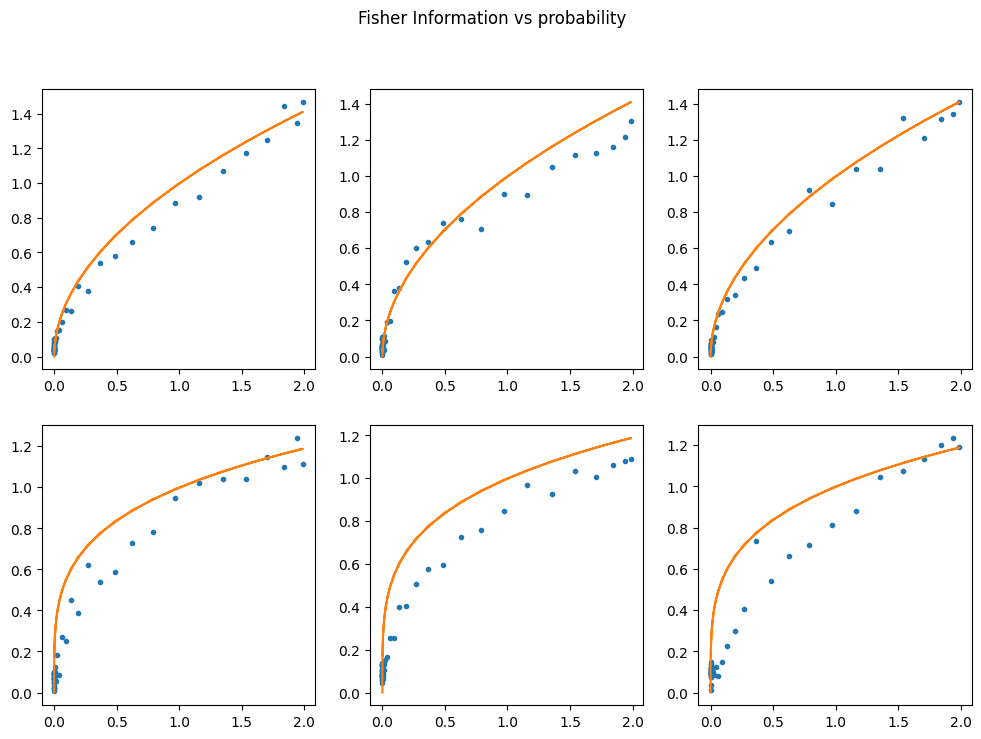

In [20]:
encoding = 'linear'

angles = np.linspace(-np.pi/2, np.pi/2, 50)
probs = norm(torch.pi/4, 0.2).pdf(angles)

figsize(12, 8)
plt.subplots(2,3)

for rep in range(3):
    for row, loss in enumerate(['linear', 'sqrt']):
        plt.subplot(2,3,3*row + rep +1)

        model = load_model(loss, encoding, 'concentrated', rep, 'train')
        FIs = Fisher_derivatives_faces_mean(model, angles)
        total = np.trapz(FIs**0.5, x=angles)
    
        plt.plot(probs, FIs**0.5 / total, '.')
        if loss == 'linear':
            plt.plot(probs, np.sqrt(probs))
        else:
            plt.plot(probs, probs**0.25)

plt.suptitle('Fisher Information vs probability')

### Fisher information, not including the square-root:

These plots seem like the square-root Fisher of the information goes as the square-root of the probability. It seems natural to compare the Fisher information directly to the probability.

Text(0.5, 1.0, 'Loss function comparison - linear embedding, concentrated distribution')

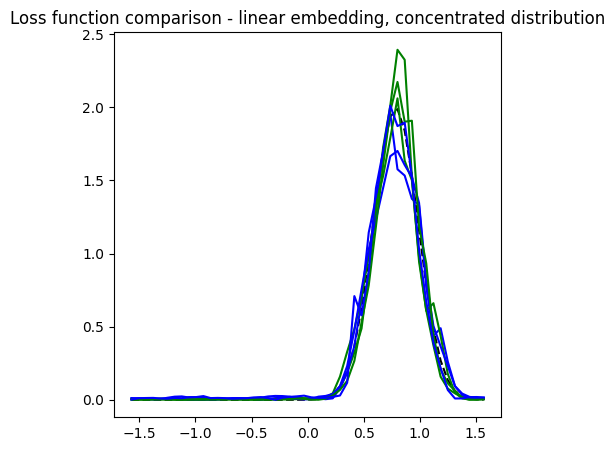

In [24]:
encoding = 'linear'

figsize(5,5)
angles = np.linspace(-np.pi/2, np.pi/2, 50)
plt.plot(angles, norm(torch.pi/4, 0.2).pdf(angles), '--k')


for rep in range(3):
    model = load_model('linear', encoding, 'concentrated', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs, x=angles)
    plt.plot(angles, FIs / total, 'g')

    model = load_model('sqrt', encoding, 'concentrated', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs, x=angles)
    plt.plot(angles, FIs / total, 'b')

plt.title('Loss function comparison - linear embedding, concentrated distribution')

Text(0.5, 0.98, 'Fisher Information vs probability')

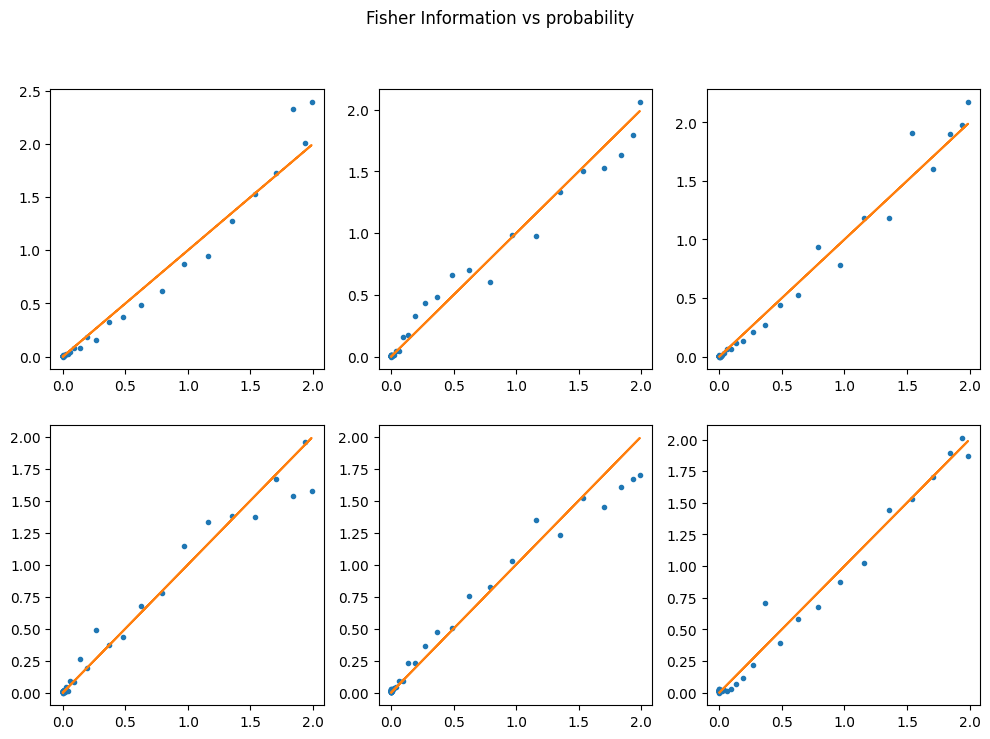

In [22]:
encoding = 'linear'

angles = np.linspace(-np.pi/2, np.pi/2, 50)
probs = norm(torch.pi/4, 0.2).pdf(angles)

figsize(12, 8)
plt.subplots(2,3)

for rep in range(3):
    for row, loss in enumerate(['linear', 'sqrt']):
        plt.subplot(2,3,3*row + rep +1)

        model = load_model(loss, encoding, 'concentrated', rep, 'train')
        FIs = Fisher_derivatives_faces_mean(model, angles)
        total = np.trapz(FIs, x=angles)
    
        plt.plot(probs, FIs / total, '.')
        plt.plot(probs, probs)

plt.suptitle('Fisher Information vs probability')

Ok, plotting Fisher info vs probability directly, we see that there is pretty much a linear dependence:

$I(s) \propto p(s)$

From our solutions, we know that

$f'(\sqrt{I(s)}) \propto \frac{1}{p(s)}$

$\implies f'(x) \propto 1 / x^2 \implies f(x) \propto -1 / x$

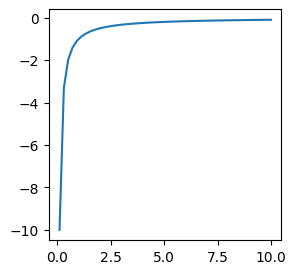

In [31]:
figsize(3,3)
xs = np.linspace(0.1, 10)
plt.plot(xs, -1/xs)

#### How can we interpret this distance metric?

Training objective: minimize the (projected) distance between encoding vectors.

Fit objective: There is more improvement from getting better where we are already good than from getting better where we are bad. (Note that this is a result of concavity)

Text(0.5, 0.98, 'Fisher Information vs probability - log log')

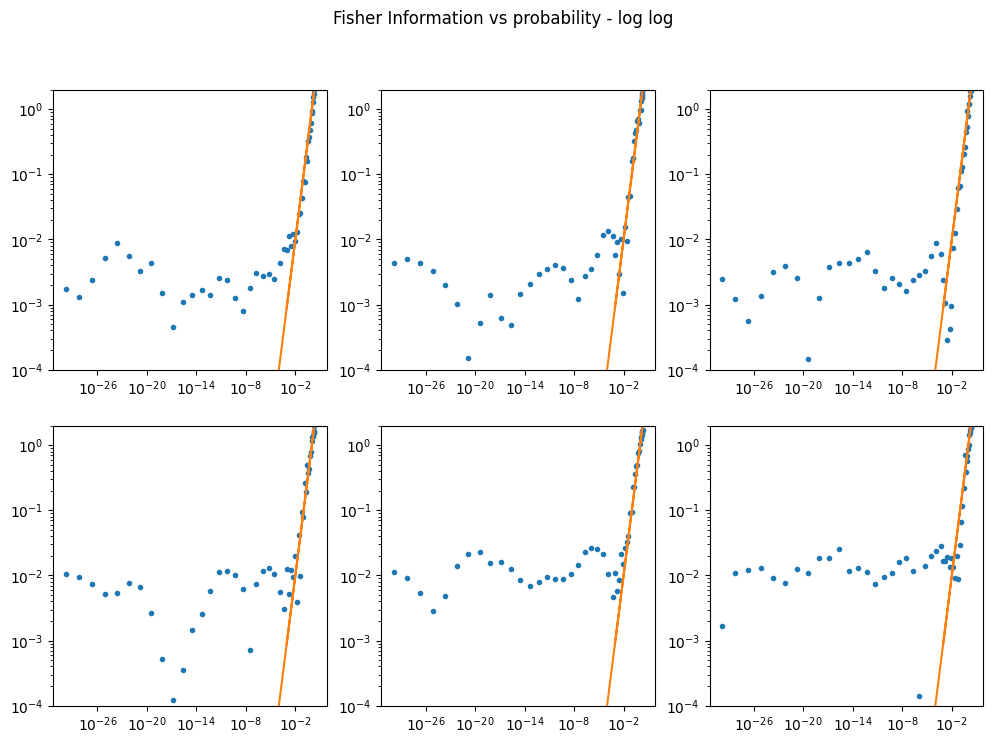

In [32]:
encoding = 'linear'

angles = np.linspace(-np.pi/2, np.pi/2, 50)
probs = norm(torch.pi/4, 0.2).pdf(angles)

figsize(12, 8)
plt.subplots(2,3)

for rep in range(3):
    for row, loss in enumerate(['linear', 'sqrt']):
        plt.subplot(2,3,3*row + rep +1)

        model = load_model(loss, encoding, 'concentrated', rep, 'train')
        FIs = Fisher_derivatives_faces_mean(model, angles)
        total = np.trapz(FIs, x=angles)
    
        plt.loglog(probs, FIs / total, '.')
        plt.loglog(probs, probs)
        plt.ylim(1E-4, 2)

plt.suptitle('Fisher Information vs probability - log log')

Interesting visualization: this detail of the very low probability regions shows that the Fisher information saturates at low probability regions: it can only get so low.

I don't think this is all that surprising. There isn't anything to be gained by removing sensitivity after a point. This might be an interesting constrained behavior, or simply a result of noise in our Fisher information measurements.

Text(0.5, 0.98, 'Fisher Information vs probability - log log')

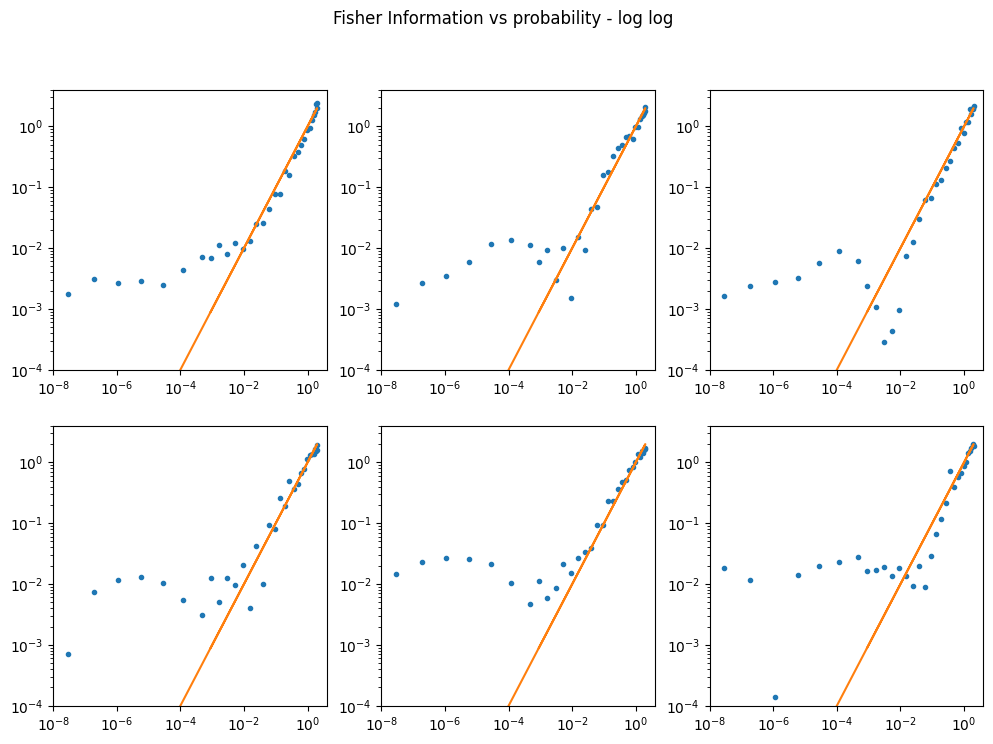

In [33]:
encoding = 'linear'

angles = np.linspace(-np.pi/2, np.pi/2, 50)
probs = norm(torch.pi/4, 0.2).pdf(angles)

figsize(12, 8)
plt.subplots(2,3)

for rep in range(3):
    for row, loss in enumerate(['linear', 'sqrt']):
        plt.subplot(2,3,3*row + rep +1)

        model = load_model(loss, encoding, 'concentrated', rep, 'train')
        FIs = Fisher_derivatives_faces_mean(model, angles)
        total = np.trapz(FIs, x=angles)
    
        plt.loglog(probs, FIs / total, '.')
        plt.loglog(probs, probs)
        plt.ylim(1E-4, 4)
        plt.xlim(1E-8, 4)

plt.suptitle('Fisher Information vs probability - log log')

#### More calculations

Assume that the baseline loss function is 

$f(x) \propto -1 / x$

Now let
$f_2(x) \propto -1 / \sqrt{x}$

$\implies f'_2(x) \propto 1 / x^{3/2}$

$\implies 1 / p(s) \propto  1/ I(s)^{3/4} $

Text(0.5, 0.98, 'Fisher Information vs probability - log log')

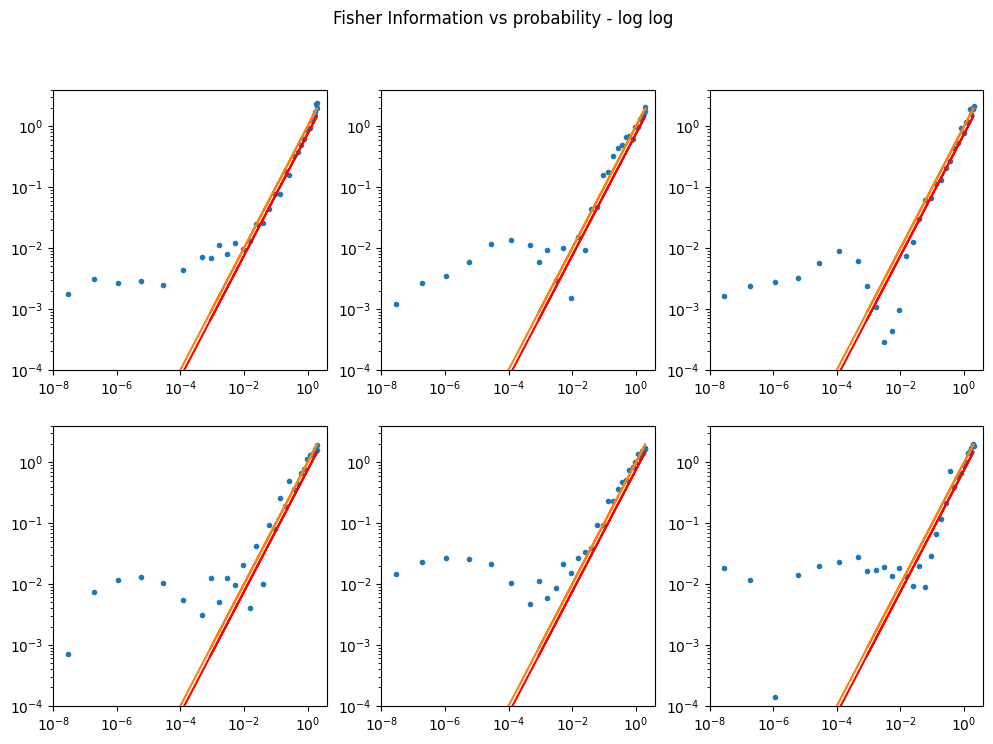

In [35]:
encoding = 'linear'

angles = np.linspace(-np.pi/2, np.pi/2, 50)
probs = norm(torch.pi/4, 0.2).pdf(angles)

figsize(12, 8)
plt.subplots(2,3)

for rep in range(3):
    for row, loss in enumerate(['linear', 'sqrt']):
        plt.subplot(2,3,3*row + rep +1)

        model = load_model(loss, encoding, 'concentrated', rep, 'train')
        FIs = Fisher_derivatives_faces_mean(model, angles)
        total = np.trapz(FIs, x=angles)
    
        plt.loglog(probs, FIs / total, '.')
        plt.loglog(probs, probs)
        plt.loglog(probs, 3/4 * probs, 'r')
        plt.ylim(1E-4, 4)
        plt.xlim(1E-8, 4)

plt.suptitle('Fisher Information vs probability - log log')

Text(0.5, 0.98, 'Fisher Information vs probability')

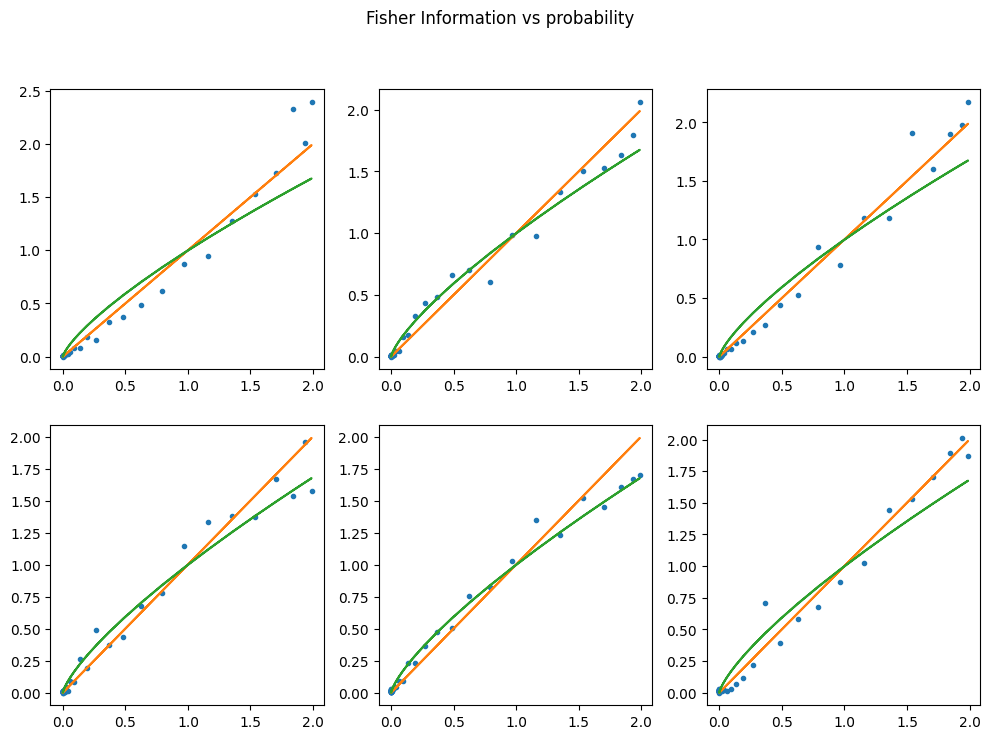

In [40]:
encoding = 'linear'

angles = np.linspace(-np.pi/2, np.pi/2, 50)
probs = norm(torch.pi/4, 0.2).pdf(angles)

figsize(12, 8)
plt.subplots(2,3)

for rep in range(3):
    for row, loss in enumerate(['linear', 'sqrt']):
        plt.subplot(2,3,3*row + rep +1)

        model = load_model(loss, encoding, 'concentrated', rep, 'train')
        FIs = Fisher_derivatives_faces_mean(model, angles)
        total = np.trapz(FIs, x=angles)
    
        plt.plot(probs, FIs / total, '.')
        plt.plot(probs, probs)
        plt.plot(probs, probs**(3/4))

plt.suptitle('Fisher Information vs probability')

Yeah, ok.... This actually looks really good. I think that we need some examples that have more aggressive deviations from linear to check this

### More agressive examples

Text(0.5, 0.98, 'Fisher Information vs probability')

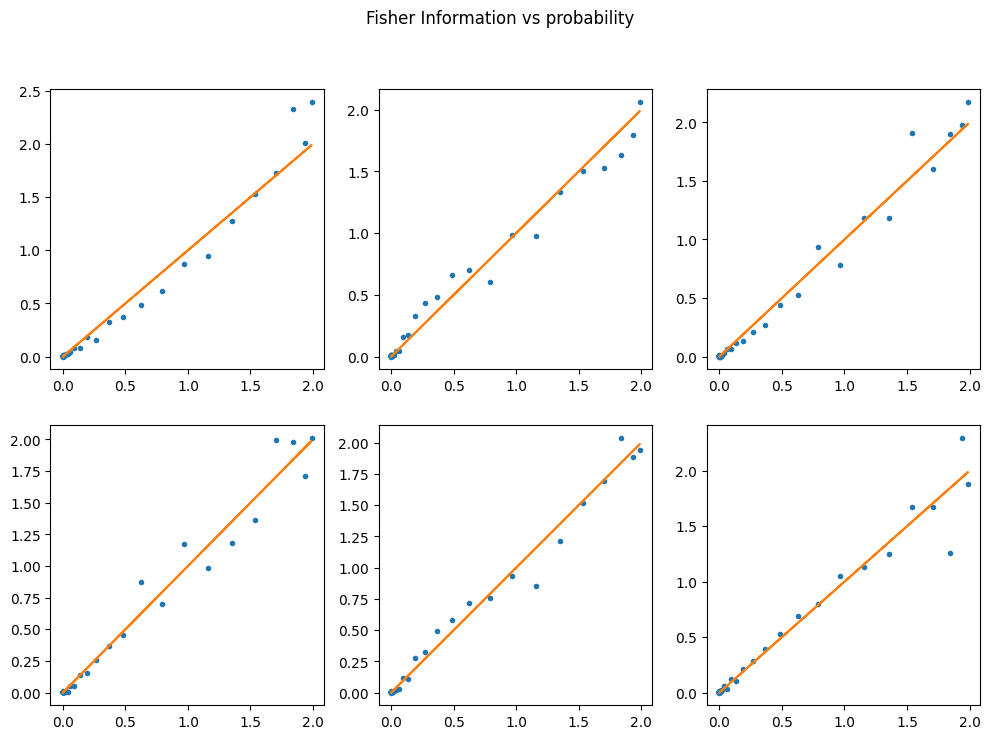

In [50]:
encoding = 'linear'

angles = np.linspace(-np.pi/2, np.pi/2, 50)
probs = norm(torch.pi/4, 0.2).pdf(angles)

figsize(12, 8)
plt.subplots(2,3)

for rep in range(3):
    for row, loss in enumerate(['linear', 'square']):
        plt.subplot(2,3,3*row + rep +1)

        model = load_model(loss, encoding, 'concentrated', rep, 'train')
        FIs = Fisher_derivatives_faces_mean(model, angles)
        total = np.trapz(FIs, x=angles)
    
        plt.plot(probs, FIs / total, '.')
        plt.plot(probs, probs)

plt.suptitle('Fisher Information vs probability')

Text(0.5, 0.98, 'Fisher Information vs probability')

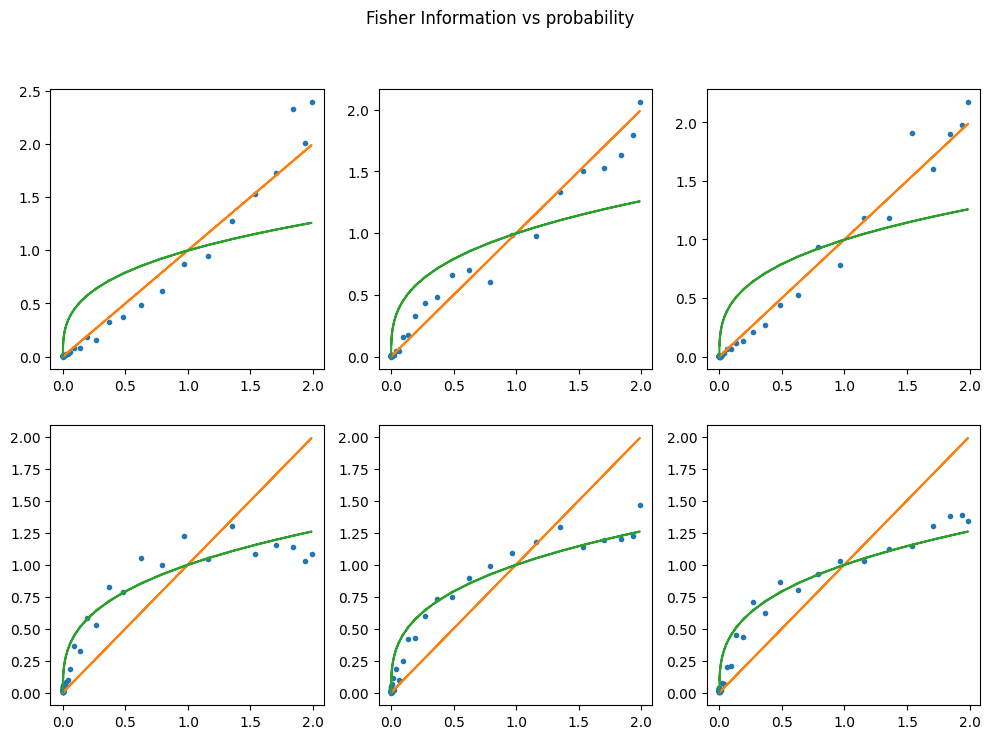

In [45]:
encoding = 'linear'

angles = np.linspace(-np.pi/2, np.pi/2, 50)
probs = norm(torch.pi/4, 0.2).pdf(angles)

figsize(12, 8)
plt.subplots(2,3)

for rep in range(3):
    for row, loss in enumerate(['linear', 'quart']):
        plt.subplot(2,3,3*row + rep +1)

        model = load_model(loss, encoding, 'concentrated', rep, 'train')
        FIs = Fisher_derivatives_faces_mean(model, angles)
        total = np.trapz(FIs, x=angles)
    
        plt.plot(probs, FIs / total, '.')
        plt.plot(probs, probs)
        plt.plot(probs, probs**(1./3))

plt.suptitle('Fisher Information vs probability')

Ok, these results are interesting, not perfect, but interesting. In particular, we _can_ get larger differences by using a more aggressive non-linearities, which is good to see. However, the square non-linearity doesn't seem to show any change from the linear case.

Whats more, the new dependence that we see looks like to $x^{1/3}$, not what we would expect:

#### Based on previous dependence:
$f'(\sqrt{I(s)}) \propto 1 / p(s)$

baseline:
$f(x) \propto -1 / x$

Now let
$f_3(x) \propto -1 / x^4$

$\implies f'_3(x) \propto 1 / x^5$

$\implies 1 / p(s) \propto  1/ I(s)^{5/2} $

#### Based on current dependence:

$p(s) \propto I(s)^{1/3}$

$\implies f'(x) \propto 1 / x^{2/3} $

$\implies f(x) \propto x^{1/3}$


Text(0.5, 0.98, 'Fisher Information vs probability')

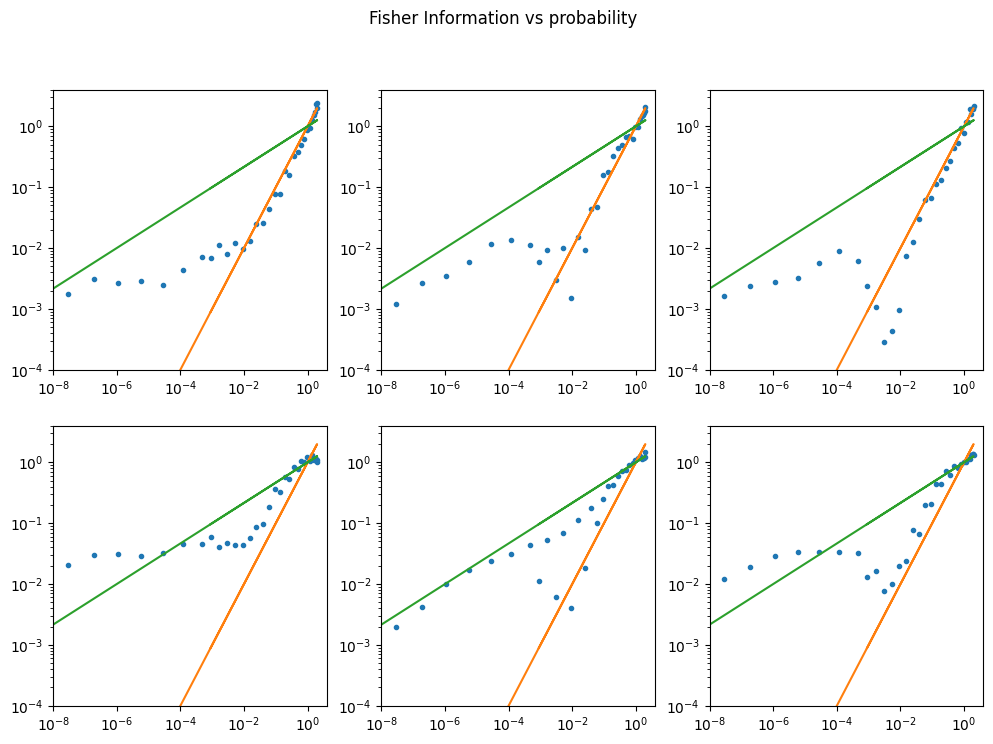

In [61]:
encoding = 'linear'

angles = np.linspace(-np.pi/2, np.pi/2, 50)
probs = norm(torch.pi/4, 0.2).pdf(angles)

figsize(12, 8)
plt.subplots(2,3)

for rep in range(3):
    for row, loss in enumerate(['linear', 'quart']):
        plt.subplot(2,3,3*row + rep +1)

        model = load_model(loss, encoding, 'concentrated', rep, 'train')
        FIs = Fisher_derivatives_faces_mean(model, angles)
        total = np.trapz(FIs, x=angles)
    
        plt.loglog(probs, FIs / total, '.')
        plt.loglog(probs, probs)
        plt.loglog(probs, probs**(1./3))
        plt.ylim(1E-4, 4)
        plt.xlim(1E-8, 4)

plt.suptitle('Fisher Information vs probability')

These plots show that at medium-low probabilities, the Fisher Information has an interesting linear dependence on the probability

Text(0.5, 0.98, 'Fisher Information vs probability')

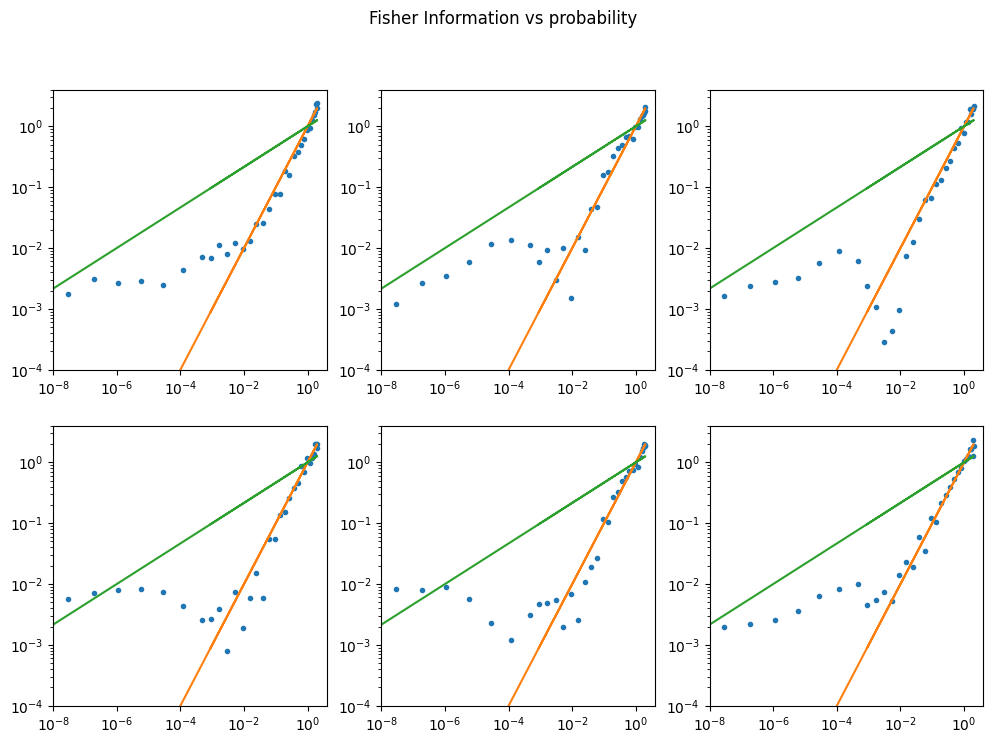

In [55]:
encoding = 'linear'

angles = np.linspace(-np.pi/2, np.pi/2, 50)
probs = norm(torch.pi/4, 0.2).pdf(angles)

figsize(12, 8)
plt.subplots(2,3)

for rep in range(3):
    for row, loss in enumerate(['linear', 'square']):
        plt.subplot(2,3,3*row + rep +1)

        model = load_model(loss, encoding, 'concentrated', rep, 'train')
        FIs = Fisher_derivatives_faces_mean(model, angles)
        total = np.trapz(FIs, x=angles)
    
        plt.loglog(probs, FIs / total, '.')
        plt.loglog(probs, probs)
        plt.loglog(probs, probs**(1./3))
        plt.ylim(1E-4, 4)
        plt.xlim(1E-8, 4)

plt.suptitle('Fisher Information vs probability')

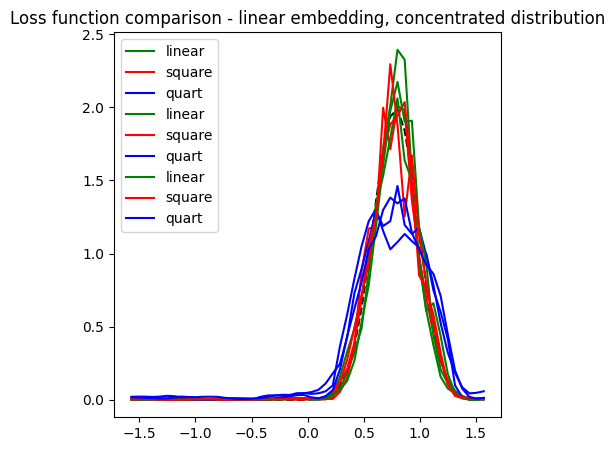

In [46]:
encoding = 'linear'

figsize(5,5)
angles = np.linspace(-np.pi/2, np.pi/2, 50)
plt.plot(angles, norm(torch.pi/4, 0.2).pdf(angles), '--k')


for rep in range(3):
    model = load_model('linear', encoding, 'concentrated', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs, x=angles)
    plt.plot(angles, FIs / total, 'g', label='linear')

    model = load_model('square', encoding, 'concentrated', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs, x=angles)
    plt.plot(angles, FIs / total, 'r', label='square')
    
    model = load_model('quart', encoding, 'concentrated', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs, x=angles)
    plt.plot(angles, FIs / total, 'b', label='quart')


plt.title('Loss function comparison - linear embedding, concentrated distribution')
plt.legend()

Ok, yes. The quartic objective function definitely sees a different dependence on probability density.

### Loking into loss functions that are even flatter than square-root

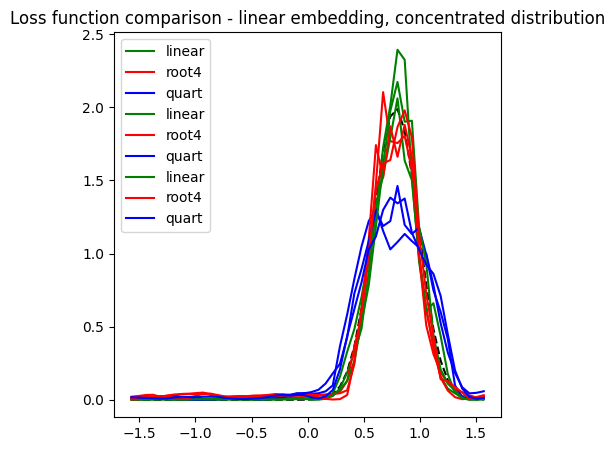

In [47]:
encoding = 'linear'

figsize(5,5)
angles = np.linspace(-np.pi/2, np.pi/2, 50)
plt.plot(angles, norm(torch.pi/4, 0.2).pdf(angles), '--k')


for rep in range(3):
    model = load_model('linear', encoding, 'concentrated', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs, x=angles)
    plt.plot(angles, FIs / total, 'g', label='linear')

    model = load_model('root4', encoding, 'concentrated', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs, x=angles)
    plt.plot(angles, FIs / total, 'r', label='root4')
    
    model = load_model('quart', encoding, 'concentrated', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs, x=angles)
    plt.plot(angles, FIs / total, 'b', label='quart')


plt.title('Loss function comparison - linear embedding, concentrated distribution')
plt.legend()

Interesting that we don't seem to ever get the opposite behavior of over-concentration on high probability locations.

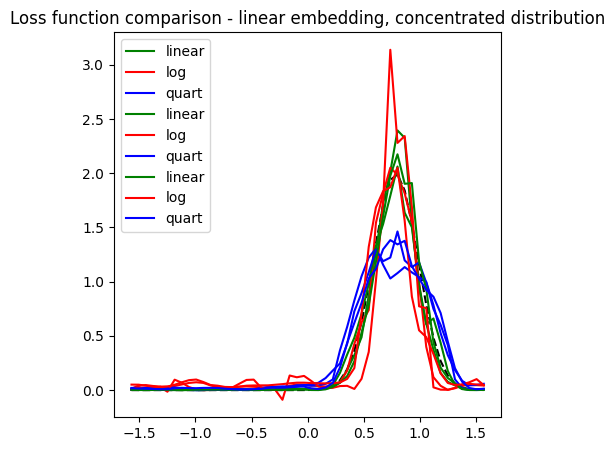

In [48]:
encoding = 'linear'

figsize(5,5)
angles = np.linspace(-np.pi/2, np.pi/2, 50)
plt.plot(angles, norm(torch.pi/4, 0.2).pdf(angles), '--k')


for rep in range(3):
    model = load_model('linear', encoding, 'concentrated', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs, x=angles)
    plt.plot(angles, FIs / total, 'g', label='linear')

    model = load_model('log', encoding, 'concentrated', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs, x=angles)
    plt.plot(angles, FIs / total, 'r', label='log')
    
    model = load_model('quart', encoding, 'concentrated', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    total = np.trapz(FIs, x=angles)
    plt.plot(angles, FIs / total, 'b', label='quart')


plt.title('Loss function comparison - linear embedding, concentrated distribution')
plt.legend()

Maybe.... Could our Fisher information measurements be under-estimating the results at concentrated points?

Text(0.5, 0.98, 'Fisher Information vs probability - flat loss functions')

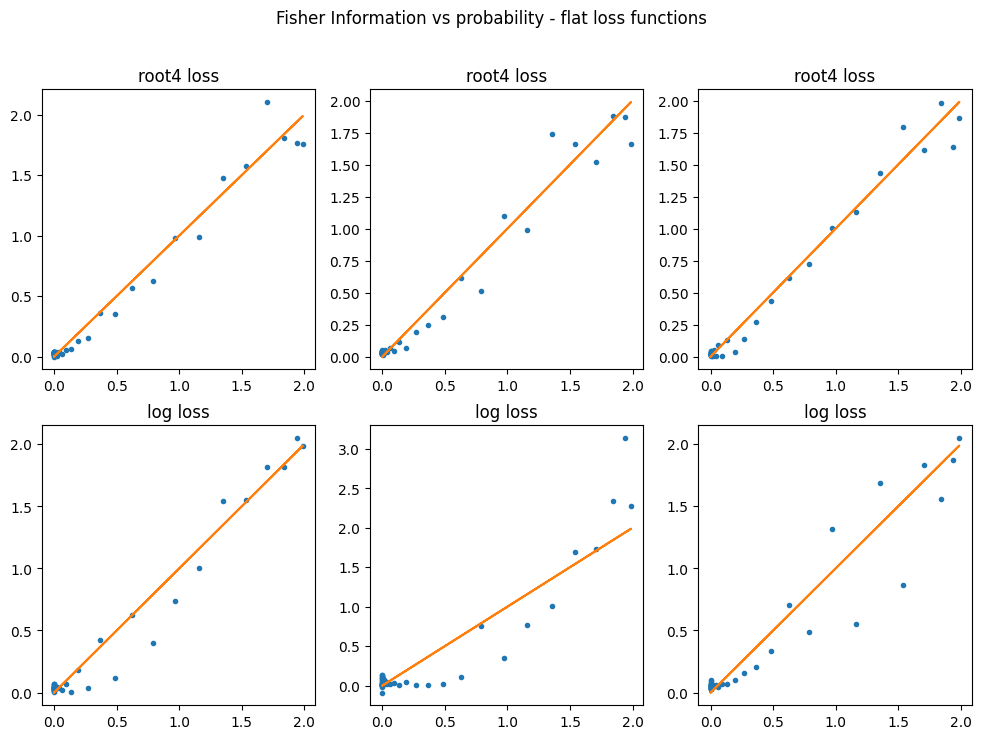

In [11]:
encoding = 'linear'

angles = np.linspace(-np.pi/2, np.pi/2, 50)
probs = norm(torch.pi/4, 0.2).pdf(angles)

figsize(12, 8)
plt.subplots(2,3)

for rep in range(3):
    for row, loss in enumerate(['root4', 'log']):
        plt.subplot(2,3,3*row + rep +1)

        model = load_model(loss, encoding, 'concentrated', rep, 'train')
        FIs = Fisher_derivatives_faces_mean(model, angles)
        total = np.trapz(FIs, x=angles)
    
        plt.plot(probs, FIs / total, '.')
        plt.plot(probs, probs)
        plt.title(f'{loss} loss')

plt.suptitle('Fisher Information vs probability - flat loss functions')

Maybe, maybe. The log results look quite promising, but at the same time, very noisy. It's even possible to convince myself that there could be super-linear curves in the 4th root loss.

### What do the encodings look like?

Text(0.5, 0.98, 'Encoding: linear loss')

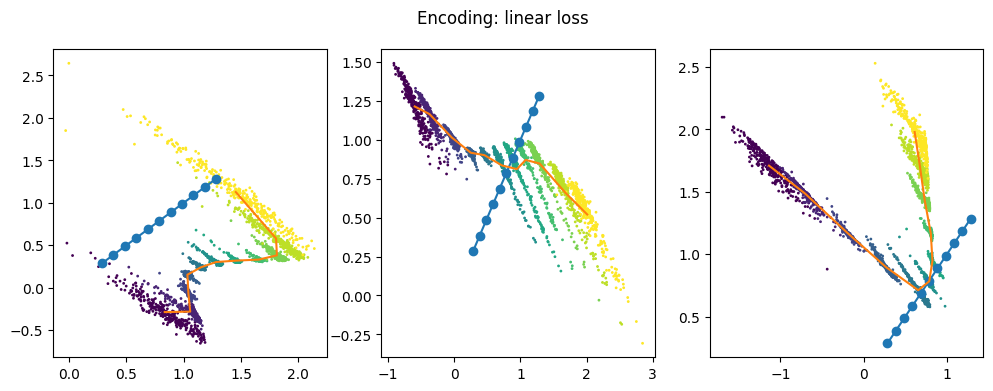

In [60]:
loss = 'linear'

figsize(12, 4)
plt.subplots(1,3)

stimuli = np.linspace(-0.5, 0.5, 11) + np.pi/4
train_data = make_data(stimuli)

for rep in range(3):
    model = load_model(loss, 'linear', 'concentrated', rep, 'train')
    outs = model.forward(train_data[:]['image'].to(model.device)).cpu().detach()

    plt.subplot(1, 3, rep+1)
    plt.scatter(outs[:, 0], outs[:,1],  c=train_data[:]['angle'], s=1)
    plt.plot(stimuli, stimuli, '-o')

    means = torch.stack(list(map(lambda x: x.mean(0), outs.split(300))))
    plt.plot(means[:,0], means[:,1] )

plt.suptitle(f'Encoding: {loss} loss')

Text(0.5, 0.98, 'Encoding: square loss')

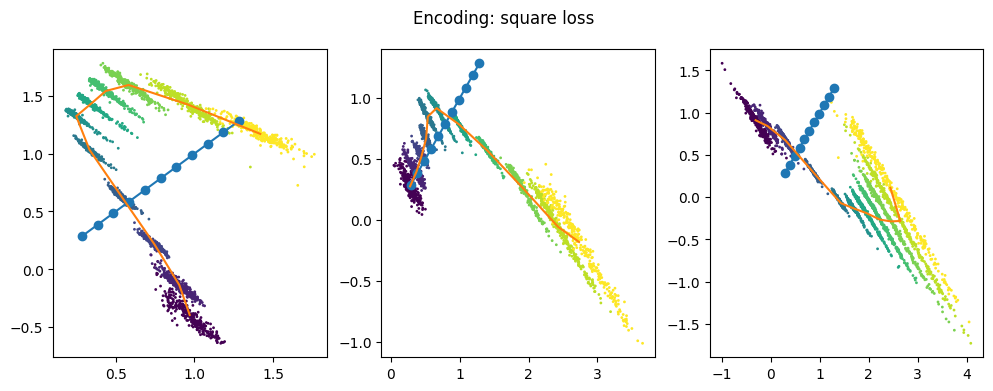

In [61]:
loss = 'square'

figsize(12, 4)
plt.subplots(1,3)

stimuli = np.linspace(-0.5, 0.5, 11) + np.pi/4
train_data = make_data(stimuli)

for rep in range(3):
    model = load_model(loss, 'linear', 'concentrated', rep, 'train')
    outs = model.forward(train_data[:]['image'].to(model.device)).cpu().detach()

    plt.subplot(1, 3, rep+1)
    plt.scatter(outs[:, 0], outs[:,1],  c=train_data[:]['angle'], s=1)
    plt.plot(stimuli, stimuli, '-o')

    means = torch.stack(list(map(lambda x: x.mean(0), outs.split(300))))
    plt.plot(means[:,0], means[:,1])

plt.suptitle(f'Encoding: {loss} loss')

Text(0.5, 0.98, 'Encoding: quart loss')

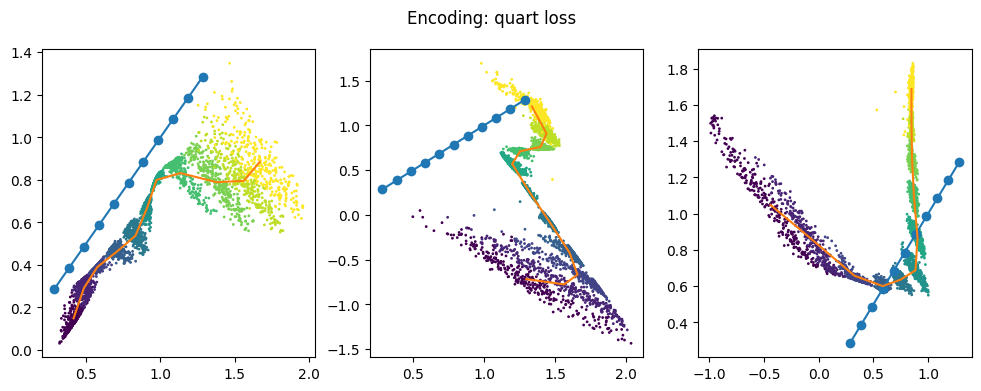

In [62]:
loss = 'quart'

figsize(12, 4)
plt.subplots(1,3)

stimuli = np.linspace(-0.5, 0.5, 11) + np.pi/4
train_data = make_data(stimuli)

for rep in range(3):
    model = load_model(loss, 'linear', 'concentrated', rep, 'train')
    outs = model.forward(train_data[:]['image'].to(model.device)).cpu().detach()

    plt.subplot(1, 3, rep+1)
    plt.scatter(outs[:, 0], outs[:,1],  c=train_data[:]['angle'], s=1)
    plt.plot(stimuli, stimuli, '-o')

    means = torch.stack(list(map(lambda x: x.mean(0), outs.split(300))))
    plt.plot(means[:,0], means[:,1])

plt.suptitle(f'Encoding: {loss} loss')

Text(0.5, 0.98, 'Encoding: root4 loss')

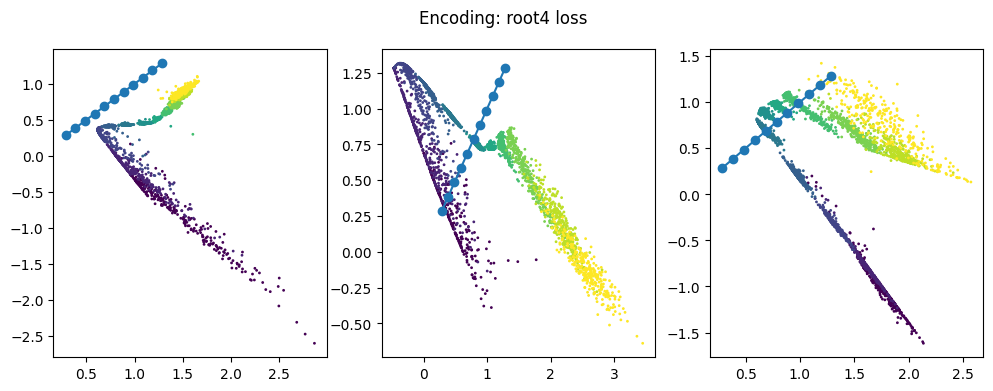

In [66]:
loss = 'root4'

figsize(12, 4)
plt.subplots(1,3)

stimuli = np.linspace(-0.5, 0.5, 11) + np.pi/4
train_data = make_data(stimuli)

for rep in range(3):
    model = load_model(loss, 'linear', 'concentrated', rep, 'train')
    outs = model.forward(train_data[:]['image'].to(model.device)).cpu().detach()

    plt.subplot(1, 3, rep+1)
    plt.scatter(outs[:, 0], outs[:,1],  c=train_data[:]['angle'], s=1)
    plt.plot(stimuli, stimuli, '-o')



plt.suptitle(f'Encoding: {loss} loss')

Text(0.5, 0.98, 'Encoding: log loss')

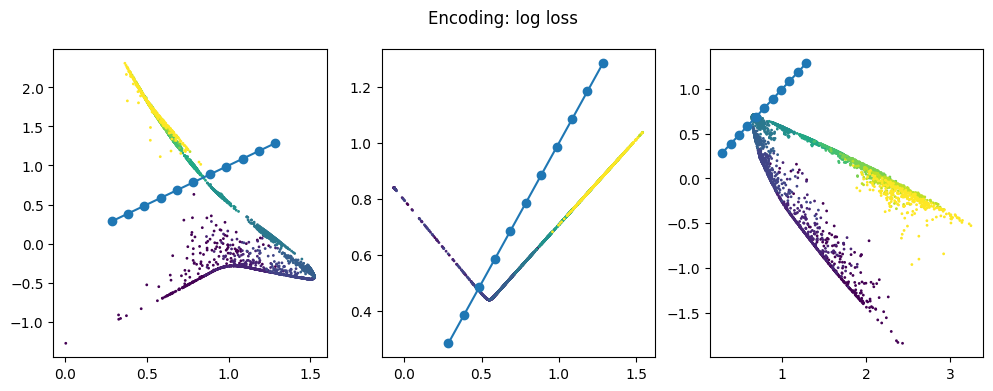

In [68]:
loss = 'log'

figsize(12, 4)
plt.subplots(1,3)

stimuli = np.linspace(-0.5, 0.5, 11) + np.pi/4
train_data = make_data(stimuli)

for rep in range(3):
    model = load_model(loss, 'linear', 'concentrated', rep, 'train')
    outs = model.forward(train_data[:]['image'].to(model.device)).cpu().detach()

    plt.subplot(1, 3, rep+1)
    plt.scatter(outs[:, 0], outs[:,1],  c=train_data[:]['angle'], s=1)
    plt.plot(stimuli, stimuli, '-o')

    means = torch.stack(list(map(lambda x: x.mean(0), outs.split(300))))
    #plt.plot(means[:,0], means[:,1])

plt.suptitle(f'Encoding: {loss} loss')

Interesting to see the degree to which these distributions are narrowly aligned _along_ the line between means. That is an quite unintuitive result, that I would think results in _less_ Fisher information at these high probability locations. However, comparing to the Fisher information, the middle replicate actually sees the _largest_ Fisher information spike...

_Note_: this is not necessarily the largest FI, just the largest FI relative to the total!

Text(0.5, 0.98, 'Encoding: log loss')

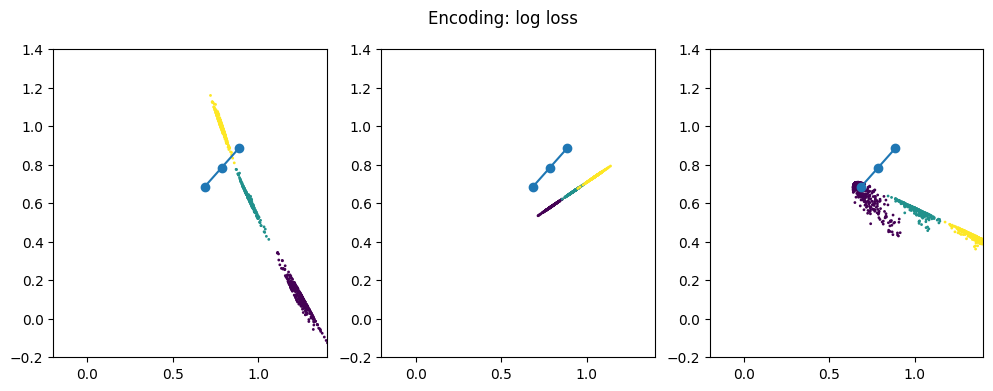

In [71]:
loss = 'log'

figsize(12, 4)
plt.subplots(1,3)

stimuli = np.linspace(-0.1, 0.1, 3) + np.pi/4
train_data = make_data(stimuli)

for rep in range(3):
    model = load_model(loss, 'linear', 'concentrated', rep, 'train')
    outs = model.forward(train_data[:]['image'].to(model.device)).cpu().detach()

    plt.subplot(1, 3, rep+1)
    plt.scatter(outs[:, 0], outs[:,1],  c=train_data[:]['angle'], s=1)
    plt.plot(stimuli, stimuli, '-o')
    plt.xlim([-0.2, 1.4])
    plt.ylim([-0.2, 1.4])

plt.suptitle(f'Encoding: {loss} loss')

Text(0.5, 0.98, 'Full Domain Encoding: log loss')

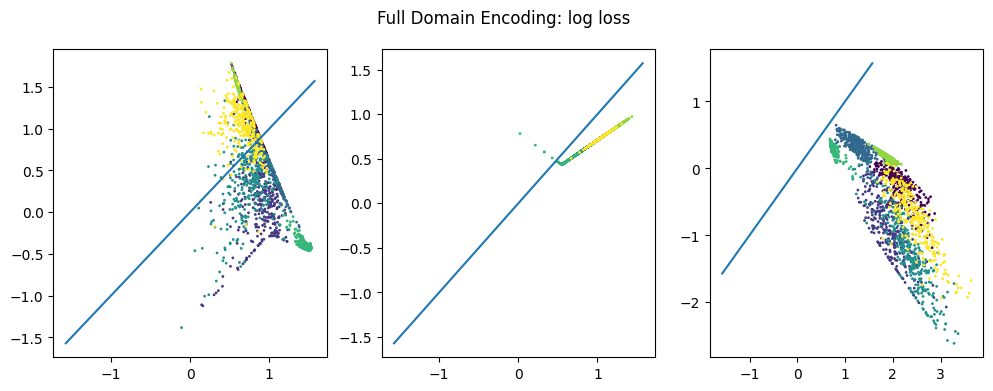

In [51]:
loss = 'log'

figsize(12, 4)
plt.subplots(1,3)

stimuli = np.linspace(-np.pi/2, np.pi/2, 7)
train_data = make_data(stimuli)

for rep in range(3):
    model = load_model(loss, 'linear', 'concentrated', rep, 'train')
    outs = model.forward(train_data[:]['image'].to(model.device)).cpu().detach()

    plt.subplot(1, 3, rep+1)
    plt.scatter(outs[:, 0], outs[:,1],  c=train_data[:]['angle'], s=1)
    plt.plot(stimuli, stimuli)



plt.suptitle(f'Full Domain Encoding: {loss} loss')

#### Questions about Fisher information measurement techniques:

I guess that the concern here would be that the Fisher information measurements work better or worse in scenarios that are specific to certain loss functions.

Additionally, there is always the question of which stimuli the Fisher information is being measured at: do we miss some very important stimuli?

Is there a way to evaluate different measurements of the Fisher information, so that we don't simply fit our measurement to the data?

#### Other questions
What probability density functions should we use to get the most information about the Fisher information curves?

In [81]:
total_FIs = []

for loss in ['linear', 'sqrt', 'square', 'quart', 'root4', 'log']:
    for rep in range(3):
        model = load_model(loss, 'linear', 'concentrated', rep, 'train')
        FIs = Fisher_derivatives_faces_mean(model, angles)
        total = np.trapz(FIs, x=angles)

        total_FIs.append({'loss': loss, 'FI': total})

total_FIs = pd.DataFrame(total_FIs)

<Axes: xlabel='loss', ylabel='FI'>

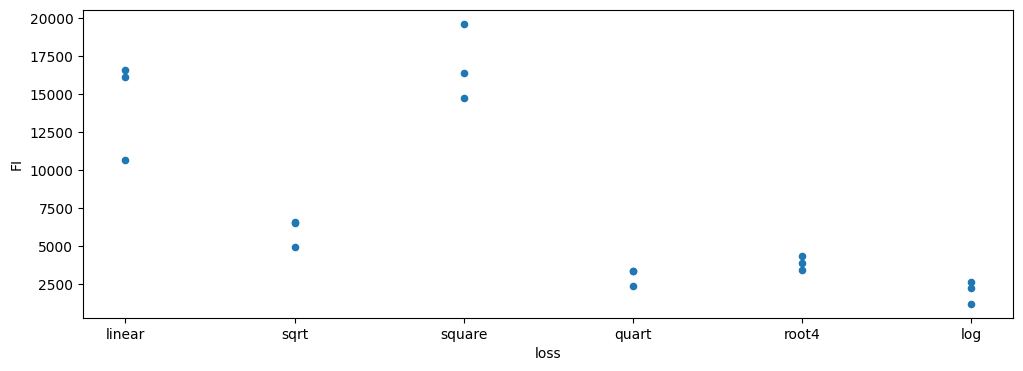

In [85]:
total_FIs.plot.scatter(x='loss', y='FI')

Interesting: the loss function has a major impact on the total Fisher information. Hard to sense a trend, however, because the quartic loss and fourth root loss both move in the same direction relative to linear.

One vague possibility is that the linear loss somehow incentivizes increasing total Fisher information the most, while the other ones put less pressure in this direction.... The loss functions that are close to linear do best by improving total Fisher information, rather than specializing. Maybe, but...

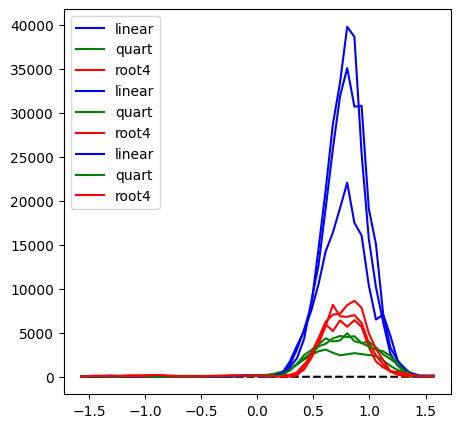

In [93]:
figsize(5,5)
angles = np.linspace(-np.pi/2, np.pi/2, 50)
plt.plot(angles, norm(torch.pi/4, 0.2).pdf(angles), '--k')

colors = {'linear':'b', 'quart':'g', 'root4':'r'}
for rep in range(3):
    for loss in ['linear', 'quart', 'root4']:
        model = load_model(loss, 'linear', 'concentrated', rep, 'train')
        FIs = Fisher_derivatives_faces_mean(model, angles)
        
        plt.plot(angles, FIs, c=colors[loss], label=loss)

plt.legend()

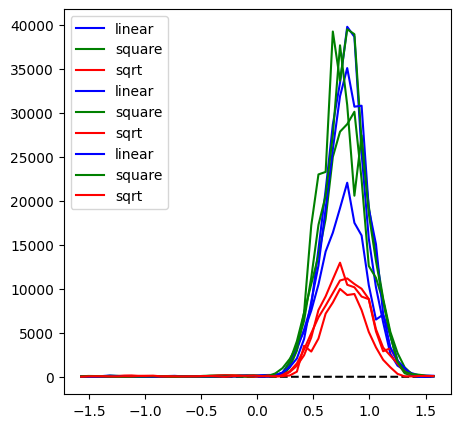

In [94]:
figsize(5,5)
angles = np.linspace(-np.pi/2, np.pi/2, 50)
plt.plot(angles, norm(torch.pi/4, 0.2).pdf(angles), '--k')

colors = {'linear':'b', 'square':'g', 'sqrt':'r'}
for rep in range(3):
    for loss in ['linear', 'square', 'sqrt']:
        model = load_model(loss, 'linear', 'concentrated', rep, 'train')
        FIs = Fisher_derivatives_faces_mean(model, angles)
        
        plt.plot(angles, FIs, c=colors[loss], label=loss)

plt.legend()

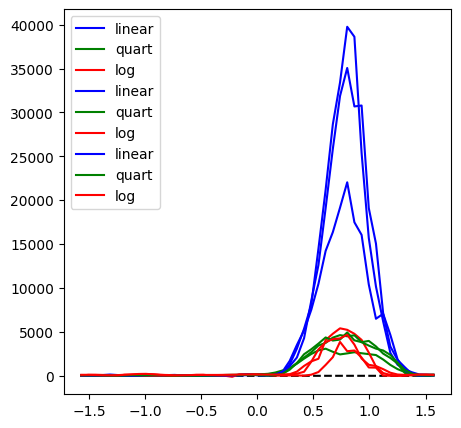

In [95]:
figsize(5,5)
angles = np.linspace(-np.pi/2, np.pi/2, 50)
plt.plot(angles, norm(torch.pi/4, 0.2).pdf(angles), '--k')

colors = {'linear':'b', 'quart':'g', 'log':'r'}
for rep in range(3):
    for loss in ['linear', 'quart', 'log']:
        model = load_model(loss, 'linear', 'concentrated', rep, 'train')
        FIs = Fisher_derivatives_faces_mean(model, angles)
        
        plt.plot(angles, FIs, c=colors[loss], label=loss)

plt.legend()

__Fairly unexpected:__ why would the magnitude of the Fisher information peak for linear loss functions? Could it be because we have a linear-like read-out of the Fisher information itself?

Aside from that, I can kind-of convince myself that roots are sharper, while the powers are blunter, but that doesn't really show up in the previous plots.

### Same plots, but plotting the square-root of the Fisher information

Text(0.5, 1.0, 'Root Fisher')

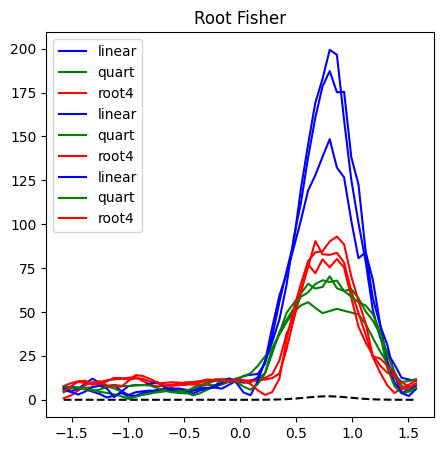

In [97]:
figsize(5,5)
angles = np.linspace(-np.pi/2, np.pi/2, 50)
plt.plot(angles, norm(torch.pi/4, 0.2).pdf(angles), '--k')

colors = {'linear':'b', 'quart':'g', 'root4':'r'}
for rep in range(3):
    for loss in ['linear', 'quart', 'root4']:
        model = load_model(loss, 'linear', 'concentrated', rep, 'train')
        FIs = Fisher_derivatives_faces_mean(model, angles)
        
        plt.plot(angles, FIs**0.5, c=colors[loss], label=loss)

plt.legend()
plt.title('Root Fisher')

Text(0.5, 1.0, 'Root Fisher')

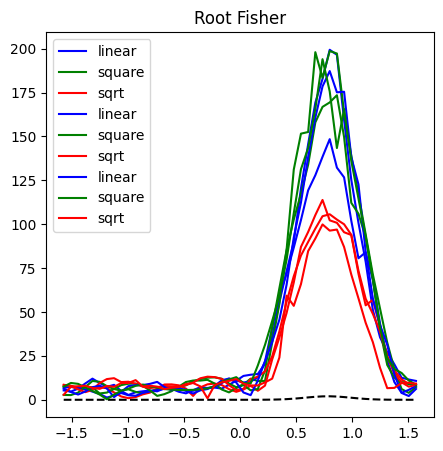

In [100]:
figsize(5,5)
angles = np.linspace(-np.pi/2, np.pi/2, 50)
plt.plot(angles, norm(torch.pi/4, 0.2).pdf(angles), '--k')

colors = {'linear':'b', 'square':'g', 'sqrt':'r'}
for rep in range(3):
    for loss in ['linear', 'square', 'sqrt']:
        model = load_model(loss, 'linear', 'concentrated', rep, 'train')
        FIs = Fisher_derivatives_faces_mean(model, angles)
        
        plt.plot(angles, FIs**0.5, c=colors[loss], label=loss)

plt.legend()
plt.title('Root Fisher')

### What does the MSE look like?

In [146]:
def mean_square_error(model, thetas):
    dataset = make_data(thetas)
    model_outs = model.decodeAngles( model.forward(dataset.images.to(model.device)) ).cpu()[0]

    mses = []
    for th in thetas:
        inds = (dataset.angles == th)
        mses.append( ((model_outs[inds] - dataset.angles[inds])**2).mean().item() )

    return np.array(mses)

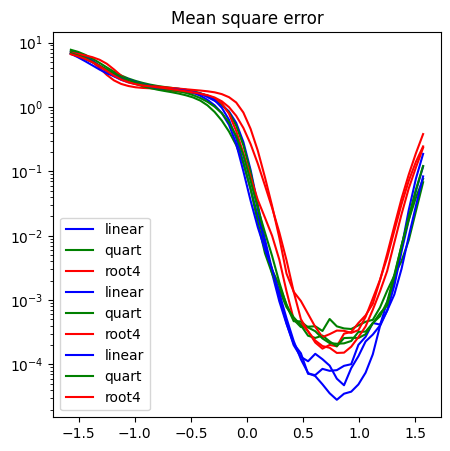

In [157]:
angles = np.linspace(-np.pi/2, np.pi/2, 50)

colors = {'linear':'b', 'quart':'g', 'root4':'r'}
for rep in range(3):
    for loss in ['linear', 'quart', 'root4']:
        model = load_model(loss, 'linear', 'concentrated', rep, 'train')
        MSE = mean_square_error(model, angles)
        
        plt.semilogy(angles, MSE, c=colors[loss], label=loss)

plt.title('Mean square error')
plt.legend()

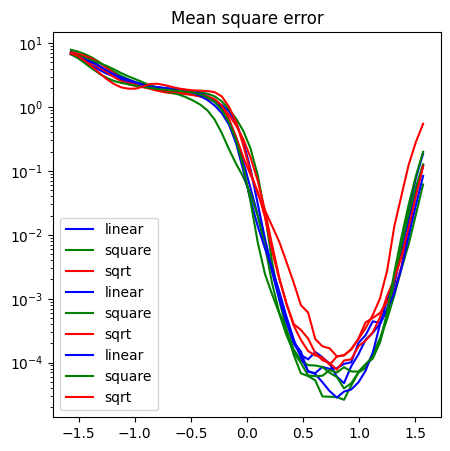

In [158]:
angles = np.linspace(-np.pi/2, np.pi/2, 50)

colors = {'linear':'b', 'square':'g', 'sqrt':'r'}
for rep in range(3):
    for loss in ['linear', 'square', 'sqrt']:
        model = load_model(loss, 'linear', 'concentrated', rep, 'train')
        MSE = mean_square_error(model, angles)
        
        plt.semilogy(angles, MSE, c=colors[loss], label=loss)

plt.title('Mean square error')
plt.legend()

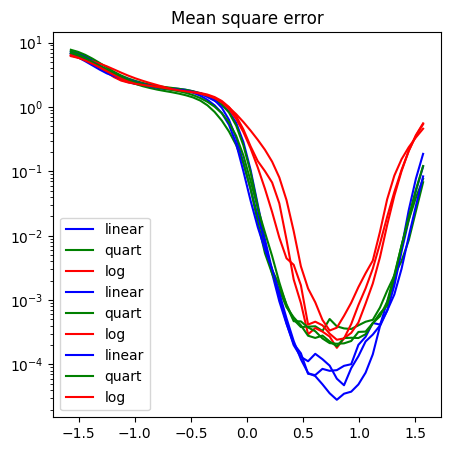

In [162]:
angles = np.linspace(-np.pi/2, np.pi/2, 50)

colors = {'linear':'b', 'quart':'g', 'log':'r'}
for rep in range(3):
    for loss in ['linear', 'quart', 'log']:
        model = load_model(loss, 'linear', 'concentrated', rep, 'train')
        MSE = mean_square_error(model, angles)
        
        plt.semilogy(angles, MSE, c=colors[loss], label=loss)

plt.title('Mean square error')
plt.legend()

Overall, the MSE trend is very similar to the Fisher information, but in reverse. This is pretty much as we would expect.

### Brainstorming:

- Fisher information looks like some kind of derivative, so shouldn't the Fisher curves go as a derivative as well?

- There don't seem to be any 'spikes' of low MSE in the log loss functions, which I would expect if they were reinforcing very accurate points


#### redoing the math
$f'(\sqrt{I(s)}) \propto 1 / p(s)$


$I(s) \propto p(s)^{1/3}$

$\implies f'(x) \propto x^{-6} $

$\implies f(x) \propto -x^{-5}$


### Looking for 'spikes'

This is what I would expect from objective functions that reinforce success, but they don't seem to show up.

Text(0.5, 1.0, 'MSE')

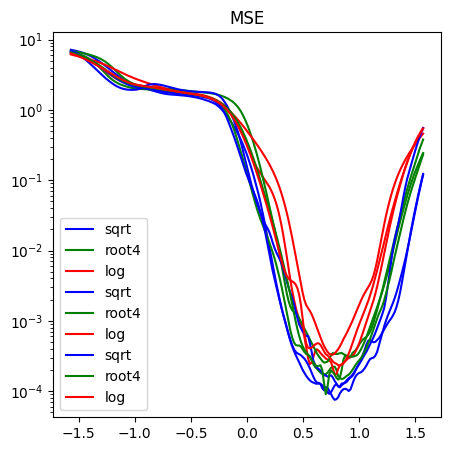

In [175]:
angles = np.linspace(-np.pi/2, np.pi/2, 200)

colors = {'sqrt':'b', 'root4':'g', 'log':'r'}
for rep in range(3):
    for loss in ['sqrt', 'root4', 'log']:
        model = load_model(loss, 'linear', 'concentrated', rep, 'train')
        MSE = mean_square_error(model, angles)
         
        if rep==0:
            plt.semilogy(angles, MSE, c=colors[loss], label=loss)
        else:
            plt.semilogy(angles, MSE, c=colors[loss], label=loss)

plt.legend()
plt.title('MSE')

Text(0.5, 1.0, 'Fisher Info')

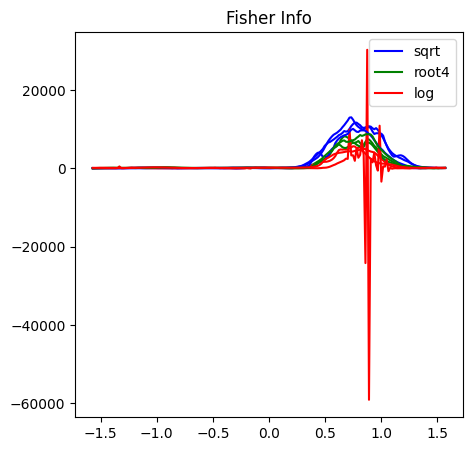

In [176]:
angles = np.linspace(-np.pi/2, np.pi/2, 200)

colors = {'sqrt':'b', 'root4':'g', 'log':'r'}
for rep in range(3):
    for loss in ['sqrt', 'root4', 'log']:
        model = load_model(loss, 'linear', 'concentrated', rep, 'train')
        FIs = Fisher_derivatives_faces_mean(model, angles)

        if rep==0:
            plt.plot(angles, FIs, c=colors[loss], label=loss)
        else:
            plt.plot(angles, FIs, c=colors[loss])

plt.legend()
plt.title('Fisher Info')

Ok, there's definitely some spikes here...

Text(0.5, 1.0, 'Fisher Info')

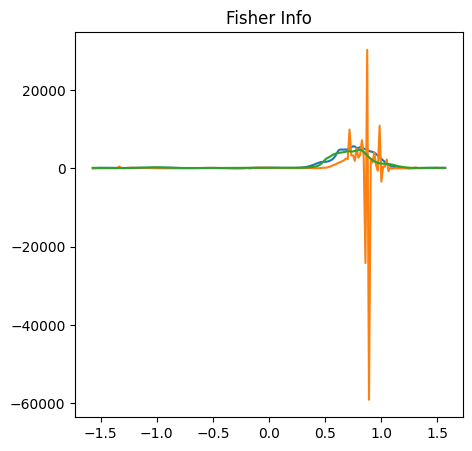

In [174]:
angles = np.linspace(-np.pi/2, np.pi/2, 200)

colors = {'sqrt':'b', 'root4':'g', 'log':'r'}
for rep in range(3):
    model = load_model('log', 'linear', 'concentrated', rep, 'train')
    FIs = Fisher_derivatives_faces_mean(model, angles)
    plt.plot(angles, FIs)


plt.title('Fisher Info')

In [177]:
angles = np.linspace(-np.pi/2, np.pi/2, 200)

model = load_model('log', 'linear', 'concentrated', 1, 'train')
FIs = Fisher_derivatives_faces_mean(model, angles)

Negative values obviously don't make any sense. Are these spikes the result of those extremely narrow covariance matrices?

In [186]:
min_data = make_data(angles[ FIs.argmin()])

In [190]:
model.forward(min_data.images.to(model.device)).cpu().T.cov()

tensor([[0.0009, 0.0005],
        [0.0005, 0.0003]], grad_fn=<SqueezeBackward0>)

In [192]:
np.linalg.inv( model.forward(min_data.images.to(model.device)).cpu().T.cov().detach() )

array([[-6.9411722e+09,  1.1400073e+10],
       [ 1.1400073e+10, -1.8723299e+10]], dtype=float32)

Probably this round-off error?

In [200]:
FIs.argmin()

156

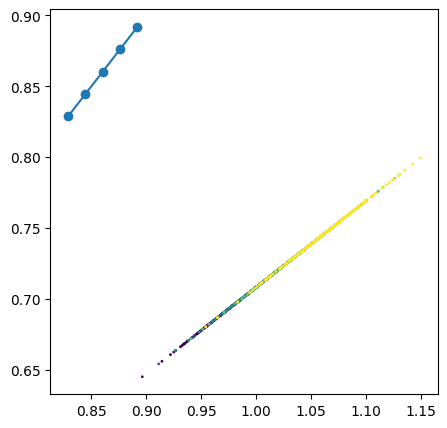

In [217]:
stimuli = angles[152:157]
train_data = make_data(stimuli)

outs = model.forward(train_data[:]['image'].to(model.device)).cpu().detach()

plt.scatter(outs[:, 0], outs[:,1],  c=train_data[:]['angle'], s=1)
plt.plot(stimuli, stimuli, '-o')

Hmmm, yeah. Really hard to see why this is much different from any other point.

#### Overall,
This is like interesting, but I don't think it's really down to the log objective function: the other replicates don't share the same behavior. If anything, its a problem with the Fisher information measurements.

### Convergence behavior for probability that matches Fisher information

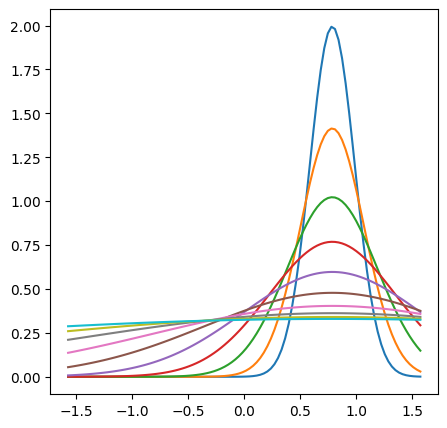

In [230]:
angles = np.linspace(-np.pi/2, np.pi/2, 100)
p = norm(torch.pi/4, 0.2).pdf(angles)

for i in range(10):
    total = np.trapz(p, angles)
    plt.plot( angles, p / total)

    p = p**0.5


It converges eventually. But it would be instant if we were to consider p / I... 

## Does the Fisher information vs probability relationship depend on context?

Here I trained networks with a variety of stepwise probability densities. The question is whether the relationship between Fisher information and probability density holds across all such samples.

In [3]:
def Fisher_derivatives_faces_mean(model, thetas, image_delta=0.05):
    """ The mean term in the Fisher information, as evaluated by derivatives of the neural network
    """
    def point_Fisher(theta):
        I0 = make_data(torch.zeros(1) + theta, split='train').images.contiguous()
        I0.requires_grad = True

        outputs = model.forward(I0.to(model.device)).cpu()
        model_grad0 = torch.autograd.grad(outputs.mean(0)[0], I0, retain_graph=True)[0]
        model_grad1 = torch.autograd.grad(outputs.mean(0)[1], I0)[0]

        plus_I0 = make_data(torch.zeros(1) + theta + image_delta/2, split='train').images.contiguous()
        minus_I0 = make_data(torch.zeros(1) + theta - image_delta/2, split='train').images.contiguous()
        image_deriv = (plus_I0 - minus_I0) / image_delta 

        full_deriv0 = (model_grad0 * image_deriv).sum().item()
        full_deriv1 = (model_grad1 * image_deriv).sum().item()
        douts = torch.tensor([full_deriv0, full_deriv1])

        cov = outputs.T.cov().detach()
        torch.mps.empty_cache()
        return (douts @ torch.linalg.inv(cov) @ douts).item()

    FIs = np.zeros(len(thetas))
    for i, theta in enumerate(thetas):
        FIs[i] = point_Fisher(theta)

    return FIs

In [108]:
%run experiments/ex2.0_exploring_more_architectures.py
model = FaceAngle.load_from_checkpoint('trainedParameters/Exp2.4/6bins/rep3/train-epoch=391-step=100352.ckpt')

<Figure size 640x480 with 0 Axes>

In [60]:
FIs = Fisher_derivatives_faces_mean(model, np.linspace(-np.pi/2, np.pi/2))

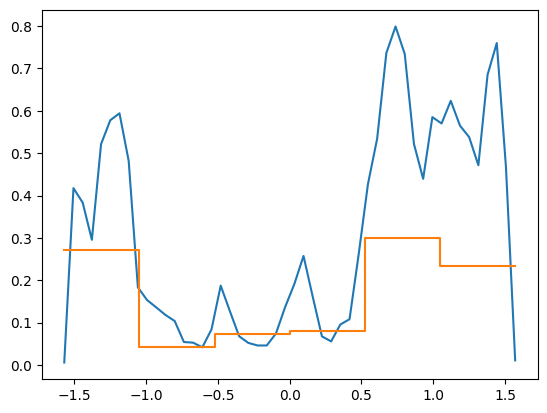

In [63]:
xs = np.linspace(-np.pi/2, np.pi/2)
total = np.trapz(FIs, xs)
plt.plot(xs, FIs / total)

bin_edge = np.linspace(-np.pi/2, np.pi/2, 7).repeat(2)[1:-1]
ps = np.repeat(model.hparams.probs,2)
plt.step(bin_edge, ps)

Do we have to make a correction to the probabilities for the bin width? They always seem to over-shoot the probability.

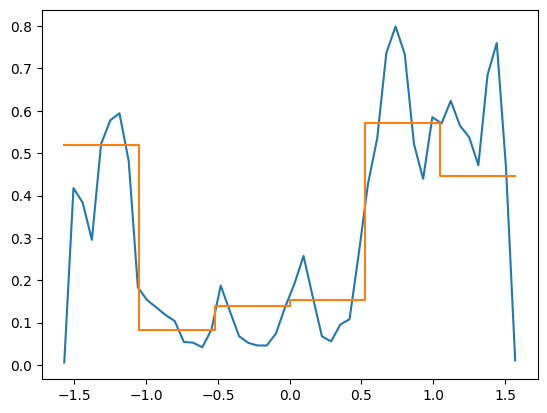

In [73]:
xs = np.linspace(-np.pi/2, np.pi/2)
total = np.trapz(FIs, xs)
plt.plot(xs, FIs / total)


step_size = bin_edge[1] - bin_edge[0]
bin_edge = np.linspace(-np.pi/2, np.pi/2, 7).repeat(2)[1:-1]
ps = np.repeat(model.hparams.probs,2) / step_size
plt.step(bin_edge, ps)

Yeah, ok. That makes sense.

In [109]:
def bin_probs(xs, ps):
    n_bins = len(ps)
    bin_edges = np.linspace(-np.pi/2, np.pi/2, n_bins+1)[1:]
    
    ys = np.zeros(xs.shape)

    
    for i, edge in enumerate(bin_edges[::-1]):
        ys[xs<=edge] = ps[::-1][i]
    return ys
    

In [110]:
xs = np.linspace(-np.pi/2, np.pi/2)
model.hparams.probs

[0.2715669548483881,
 0.04291481716740242,
 0.07315066801665938,
 0.07992312441821484,
 0.2986619775141089,
 0.23378245803522635]

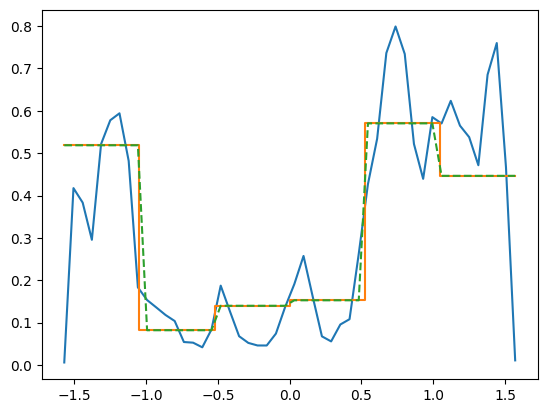

In [111]:
xs = np.linspace(-np.pi/2, np.pi/2)
total = np.trapz(FIs, xs)
plt.plot(xs, FIs / total)


bin_edge = np.linspace(-np.pi/2, np.pi/2, 7).repeat(2)[1:-1]
step_size = bin_edge[1] - bin_edge[0]

ps = np.repeat(model.hparams.probs,2) / step_size
plt.step(bin_edge, ps)

plt.plot(xs, bin_probs(xs, np.array(model.hparams.probs)/step_size), '--')

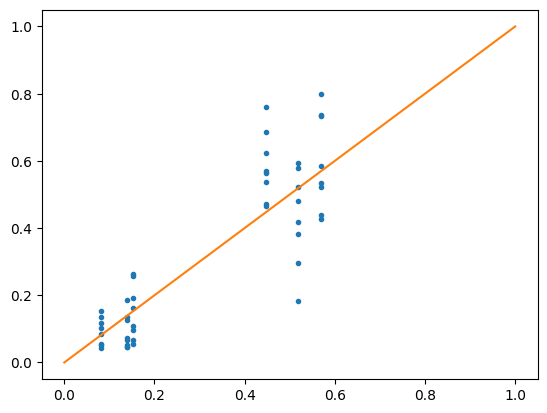

In [112]:
FI_norm = FIs / total
ps =  bin_probs(xs, np.array(model.hparams.probs)/step_size)
plt.plot(ps[1:-1], FI_norm[1:-1], '.')
plt.plot(np.linspace(0, 1), np.linspace(0,1))

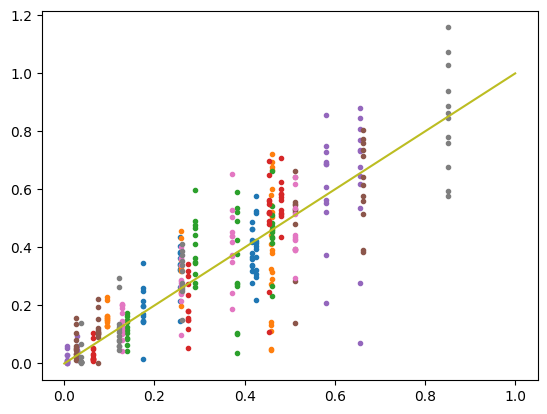

In [125]:
xs = np.linspace(-np.pi/2, np.pi/2)

for rep in range(8):
    ckpt = glob.glob(f'trainedParameters/Exp2.4/4bins/rep{rep}/*')[0]
    model =  FaceAngle.load_from_checkpoint(ckpt)

    FIs = Fisher_derivatives_faces_mean(model, xs)
    total = np.trapz(FIs, xs)
    FI_norm = FIs / total

    p = np.array(model.hparams.probs)
    step_size = np.pi / len(p)
    ps =  bin_probs(xs, p/step_size)


    plt.plot(ps[1:-1], FI_norm[1:-1], '.')

plt.plot(np.linspace(0, 1), np.linspace(0,1))

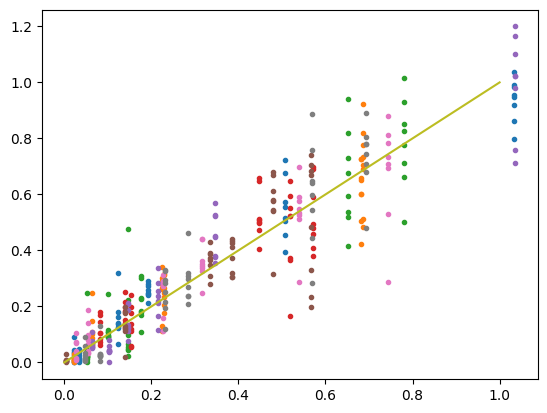

In [126]:
xs = np.linspace(-np.pi/2, np.pi/2)

for rep in range(8):
    ckpt = glob.glob(f'trainedParameters/Exp2.4/6bins/rep{rep}/*')[0]
    model =  FaceAngle.load_from_checkpoint(ckpt)

    FIs = Fisher_derivatives_faces_mean(model, xs)
    total = np.trapz(FIs, xs)
    FI_norm = FIs / total

    p = np.array(model.hparams.probs)
    step_size = np.pi / len(p)
    ps =  bin_probs(xs, p/step_size)


    plt.plot(ps[1:-1], FI_norm[1:-1], '.')

plt.plot(np.linspace(0, 1), np.linspace(0,1))

Ok, so, these results are pretty noisy, more so than I was really expecting within the individual bins.
On the other hand, the results also seem fairly consistent between bins: the mean variance is about consistent with the variance within bins.
The fact that the variance is larger for 4 bins than for 6 bins indicates nothing to me: I think it is a result of more room for fluctuations in larger bins.

All that said, these results suggest that, for linear loss functions, the relationship between sensitivity and and probability density is pretty consistently linear.

## Finetuning behavior

In [16]:
def Fisher_derivatives_faces_mean(model, thetas, image_delta=0.05):
    """ The mean term in the Fisher information, as evaluated by derivatives of the neural network
    """
    def point_Fisher(theta):
        I0 = make_data(torch.zeros(1) + theta, split='train').images.contiguous()
        I0.requires_grad = True

        outputs = model.forward(I0.to(model.device)).cpu()
        model_grad0 = torch.autograd.grad(outputs.mean(0)[0], I0, retain_graph=True)[0]
        model_grad1 = torch.autograd.grad(outputs.mean(0)[1], I0)[0]

        plus_I0 = make_data(torch.zeros(1) + theta + image_delta/2, split='train').images.contiguous()
        minus_I0 = make_data(torch.zeros(1) + theta - image_delta/2, split='train').images.contiguous()
        image_deriv = (plus_I0 - minus_I0) / image_delta 

        full_deriv0 = (model_grad0 * image_deriv).sum().item()
        full_deriv1 = (model_grad1 * image_deriv).sum().item()
        douts = torch.tensor([full_deriv0, full_deriv1])

        cov = outputs.T.cov().detach()
        torch.mps.empty_cache()
        return (douts @ torch.linalg.inv(cov) @ douts).item()

    FIs = np.zeros(len(thetas))
    for i, theta in enumerate(thetas):
        FIs[i] = point_Fisher(theta)

    return FIs

def normalized_root_Fisher(FIs, thetas):
    total = np.trapz(FIs**0.5, thetas)
    return FIs**0.5 / total

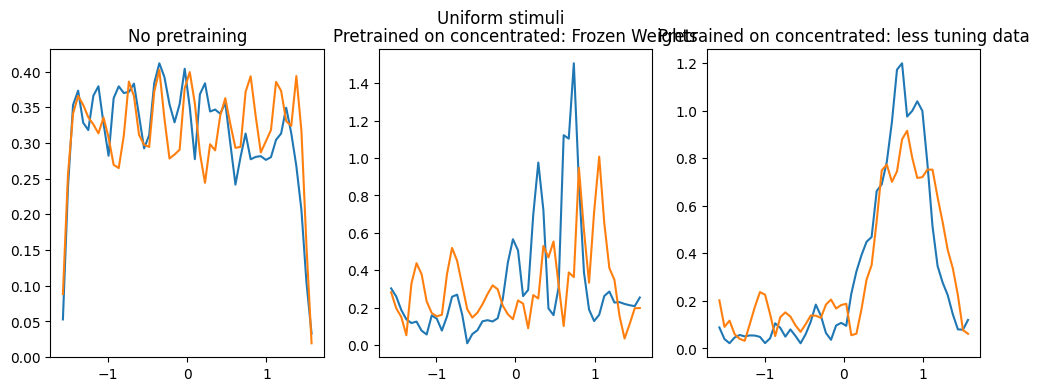

In [24]:
uniform_dir = 'trainedParameters/Exp2.5/linear_enc/uniform/'
concentrated_dir = 'trainedParameters/Exp2.5/linear_enc/concentrated/'

figsize(12, 4)
plt.subplots(1, 3 )
plt.suptitle('Uniform stimuli')

theta = np.linspace(-np.pi/2, np.pi/2, 50)
for rep in range(2):
    plt.subplot(1,3,1)
    ckpt_init = glob.glob(uniform_dir + f'rep{rep}/initial/val*')[0]
    model = FaceAngle.load_from_checkpoint(ckpt_init)
    FI = Fisher_derivatives_faces_mean(model, theta)
    plt.plot(theta, normalized_root_Fisher(FI, theta))
    plt.title('No pretraining')


    plt.subplot(1,3,2)
    ckpt_ft = glob.glob(concentrated_dir + f'rep{rep}/finetune_frozen/val*')[0]
    model = FaceAngle.load_from_checkpoint(ckpt_ft)
    FI = Fisher_derivatives_faces_mean(model, theta)
    plt.plot(theta, normalized_root_Fisher(FI, theta))
    plt.title('Pretrained on concentrated: Frozen Weights')

    plt.subplot(1,3,3)
    ckpt_ft = glob.glob(concentrated_dir + f'rep{rep}/finetune_lowdata/val*')[0]
    model = FaceAngle.load_from_checkpoint(ckpt_ft)
    FI = Fisher_derivatives_faces_mean(model, theta)
    plt.plot(theta, normalized_root_Fisher(FI, theta))
    plt.title('Pretrained on concentrated: less tuning data')
    

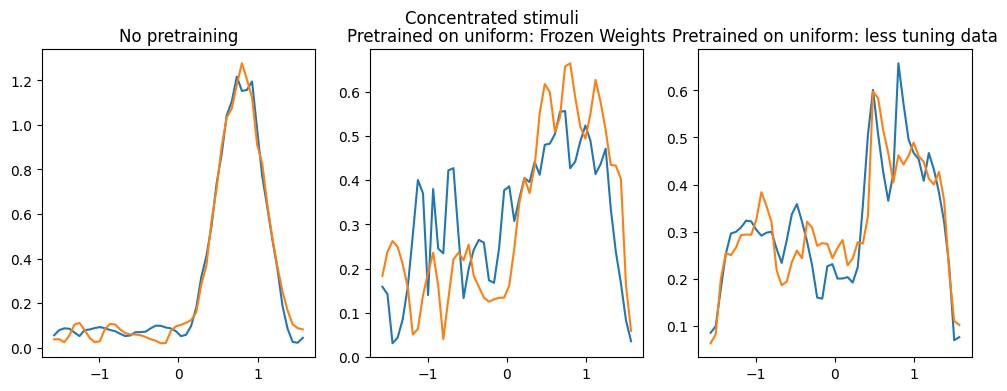

In [28]:
uniform_dir = 'trainedParameters/Exp2.5/linear_enc/uniform/'
concentrated_dir = 'trainedParameters/Exp2.5/linear_enc/concentrated/'

figsize(12, 4)
plt.subplots(1, 3 )
plt.suptitle('Concentrated stimuli')

theta = np.linspace(-np.pi/2, np.pi/2, 50)
for rep in range(2):
    plt.subplot(1,3,1)
    ckpt_init = glob.glob(concentrated_dir + f'rep{rep}/initial/val*')[0]
    model = FaceAngle.load_from_checkpoint(ckpt_init)
    FI = Fisher_derivatives_faces_mean(model, theta)
    plt.plot(theta, normalized_root_Fisher(FI, theta))
    plt.title('No pretraining')


    plt.subplot(1,3,2)
    ckpt_ft = glob.glob(uniform_dir + f'rep{rep}/finetune_frozen/val*')[0]
    model = FaceAngle.load_from_checkpoint(ckpt_ft)
    FI = Fisher_derivatives_faces_mean(model, theta)
    plt.plot(theta, normalized_root_Fisher(FI, theta))
    plt.title('Pretrained on uniform: Frozen Weights')

    plt.subplot(1,3,3)
    ckpt_ft = glob.glob(uniform_dir + f'rep{rep}/finetune_lowdata/val*')[0]
    model = FaceAngle.load_from_checkpoint(ckpt_ft)
    FI = Fisher_derivatives_faces_mean(model, theta)
    plt.plot(theta, normalized_root_Fisher(FI, theta))
    plt.title('Pretrained on uniform: less tuning data')

Ok. The previous results hold up: pretraining does impose a constraint on the weights, with the result that the Fisher Information ends up closer to the pretrained version.

Interestingly, we also see here that finetuning with less data seems to have a different effect from freezing the weights during finetuning. In particular, the frozen weights produce a 'spikier' Fisher information, while using less data produces smoother curves. This make sense to me: allowing all of the weights to change allows the networks to capture the smooth probability density more easily.

Also note how poorly the uniform finetuning works. In this sense, frozen weights might actually make more sense: they at least start to resemble the uniform distribution.

#### Circular encodings:

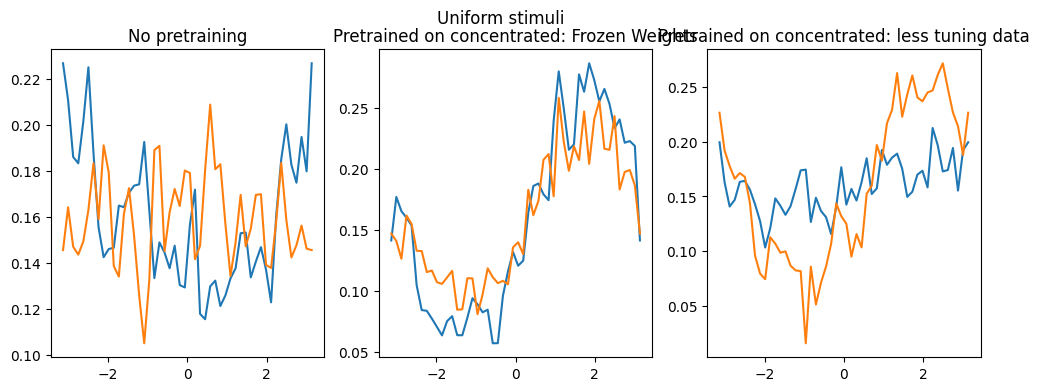

In [30]:
uniform_dir = 'trainedParameters/Exp2.5/circular_enc/uniform/'
concentrated_dir = 'trainedParameters/Exp2.5/circular_enc/concentrated/'

figsize(12, 4)
plt.subplots(1, 3 )
plt.suptitle('Uniform stimuli')

theta = np.linspace(-np.pi, np.pi, 50)
for rep in range(2):
    plt.subplot(1,3,1)
    ckpt_init = glob.glob(uniform_dir + f'rep{rep}/initial/val*')[0]
    model = FaceAngle.load_from_checkpoint(ckpt_init)
    FI = Fisher_derivatives_faces_mean(model, theta)
    plt.plot(theta, normalized_root_Fisher(FI, theta))
    plt.title('No pretraining')


    plt.subplot(1,3,2)
    ckpt_ft = glob.glob(concentrated_dir + f'rep{rep}/finetune_frozen/val*')[0]
    model = FaceAngle.load_from_checkpoint(ckpt_ft)
    FI = Fisher_derivatives_faces_mean(model, theta)
    plt.plot(theta, normalized_root_Fisher(FI, theta))
    plt.title('Pretrained on concentrated: Frozen Weights')

    plt.subplot(1,3,3)
    ckpt_ft = glob.glob(concentrated_dir + f'rep{rep}/finetune_lowdata/val*')[0]
    model = FaceAngle.load_from_checkpoint(ckpt_ft)
    FI = Fisher_derivatives_faces_mean(model, theta)
    plt.plot(theta, normalized_root_Fisher(FI, theta))
    plt.title('Pretrained on concentrated: less tuning data')
    

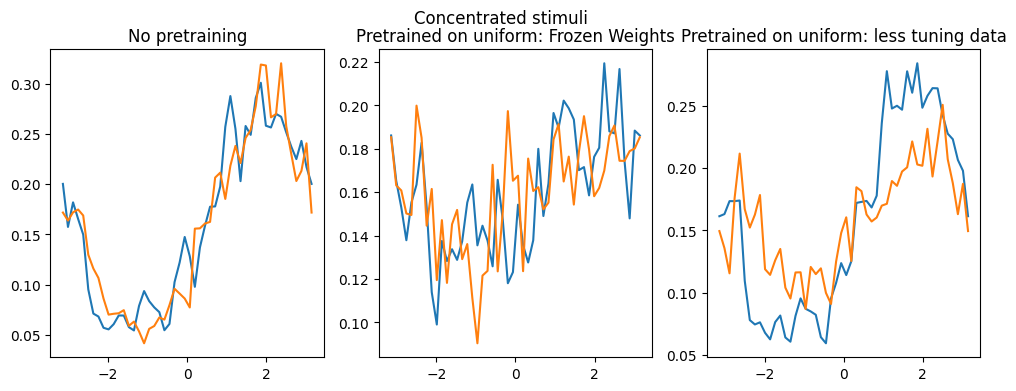

In [31]:
uniform_dir = 'trainedParameters/Exp2.5/circular_enc/uniform/'
concentrated_dir = 'trainedParameters/Exp2.5/circular_enc/concentrated/'

figsize(12, 4)
plt.subplots(1, 3 )
plt.suptitle('Concentrated stimuli')

theta = np.linspace(-np.pi, np.pi, 50)
for rep in range(2):
    plt.subplot(1,3,1)
    ckpt_init = glob.glob(concentrated_dir + f'rep{rep}/initial/val*')[0]
    model = FaceAngle.load_from_checkpoint(ckpt_init)
    FI = Fisher_derivatives_faces_mean(model, theta)
    plt.plot(theta, normalized_root_Fisher(FI, theta))
    plt.title('No pretraining')


    plt.subplot(1,3,2)
    ckpt_ft = glob.glob(uniform_dir + f'rep{rep}/finetune_frozen/val*')[0]
    model = FaceAngle.load_from_checkpoint(ckpt_ft)
    FI = Fisher_derivatives_faces_mean(model, theta)
    plt.plot(theta, normalized_root_Fisher(FI, theta))
    plt.title('Pretrained on uniform: Frozen Weights')

    plt.subplot(1,3,3)
    ckpt_ft = glob.glob(uniform_dir + f'rep{rep}/finetune_lowdata/val*')[0]
    model = FaceAngle.load_from_checkpoint(ckpt_ft)
    FI = Fisher_derivatives_faces_mean(model, theta)
    plt.plot(theta, normalized_root_Fisher(FI, theta))
    plt.title('Pretrained on uniform: less tuning data')

Interestingly, the circular encoding seems to almost have the opposite behavior: low data training produces _more_ adaptation than training with frozen weights. These are pretty noisy data, however.